## Modeling for predicting hospitalization at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. One-Hot-Encoding for Categorical Variable
3. Modeling script
4. Performance output

== Correlation analysis. Then do hyperparameter tuning.

Objective: To create a model that can predict a patient's need for hospital admission at the time of triage.

The **"time of triage"** is an important consideration as this would mean certain information "after the triage" (for e.g. ED length of stay) would not be available at that point.

### Load train and test

In [1]:
import os
import time
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import spearmanr
from pprint import pprint

from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier

from helpers6 import PlotROCCurve

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix, recall_score, f1_score, precision_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [44]:
# output_path = 'C:\\Users\\kkb74\\Documents\\SMU Study\\ISSS623 - HealthCare Analytics\\Project\\Group Project Data'

# path = output_path
# df_train = pd.read_csv((os.path.join(path, 'train2.csv')))
# df_test = pd.read_csv((os.path.join(path, 'test2.csv')))
# confidence_interval = 95
# random_seed=0

In [2]:
output_path = 'C:\\Users\\NYX\\Desktop\\AHA Group project\\Dropped dataset'

path = output_path
df_train = pd.read_csv((os.path.join(path, 'train_drop_v3.csv')))
df_test = pd.read_csv((os.path.join(path, 'test_drop_v3.csv')))
confidence_interval = 95
random_seed=0

In [3]:
pd.set_option('display.max_columns', 135) 
pd.set_option('display.max_rows', 100) 
print(df_train.shape)
df_train.tail()

(273032, 109)


,intime_ed,outtime_ed,gender,age,outcome_hospitalization,outcome_inhospital_mortality,ed_death,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,insurance_Medicaid,insurance_Medicare,insurance_Other,age_group_Young Adults,age_group_Middle-Aged Adults,age_group_Older Adults,age_group_Elderly,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
273027,2137-10-26 17:40:00,2137-10-26 22:01:00,0,89.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,4.35,37.833333,86.0,18.0,96.0,117.0,58.0,0.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.888889,66.0,16.0,97.0,143.0,96.0,0.0,2.0,18.0,0,1,0,0,0,0,1,77.666667,5,9,6,0,0,1
273028,2170-10-15 11:06:00,2170-10-15 11:26:00,0,29.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,36.722222,77.0,18.0,100.0,130.0,74.0,0.0,3.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.111111,64.0,20.0,100.0,109.0,74.0,0.0,2.0,0.0,0,0,0,1,0,0,0,92.666667,0,0,0,0,0,1
273029,2153-12-22 20:21:00,2153-12-22 20:36:00,0,23.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0.25,36.277778,99.0,18.0,100.0,131.0,81.0,5.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,36.666667,84.0,18.0,98.0,106.0,48.0,2.0,4.0,2.0,0,0,0,1,0,0,0,97.666667,1,0,0,1,1,1
273030,2192-12-04 18:34:00,2192-12-04 18:38:00,0,65.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0.07,37.722222,83.0,16.0,96.0,117.0,74.0,5.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,36.888889,81.0,18.0,98.0,110.0,72.0,0.0,9.0,10.0,0,0,0,0,0,1,0,88.333333,3,4,5,0,0,1
273031,2209-02-23 03:55:00,2209-02-23 05:29:00,1,64.0,0,0,0,0,0,0,1,2,1,0,0,0,0,0,0,1.57,35.944444,83.0,28.0,96.0,166.0,100.0,0.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,37.000000,74.0,22.0,96.0,147.0,83.0,0.0,2.0,28.0,0,0,0,0,1,0,0,122.000000,5,19,6,4,4,2


### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
# check
print(f'''number of ed_death: {(df_train['ed_death'] == True).sum()}''')
print(f'''number of rows with missing triage acuity: {df_train['triage_acuity'].isna().sum()}''')

number of ed_death: 0
number of rows with missing triage acuity: 0


In [63]:
# # "ed_death" is a Boolean field that is marked if patient died in that ED encounter
# # Need to also .reset the index() for df_train dataset as well after removing the records with 'ed_death' == True
# df_train = df_train[df_train['ed_death'] == False].reset_index()
# df_test = df_test[df_test['ed_death'] == False].reset_index()

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273032 entries, 0 to 273031
Columns: 109 entries, intime_ed to score_MEWS
dtypes: float64(20), int64(87), object(2)
memory usage: 227.1+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68258 entries, 0 to 68257
Columns: 109 entries, intime_ed to score_MEWS
dtypes: float64(20), int64(87), object(2)
memory usage: 56.8+ MB


(ii) Create "day_of_week", "hour_of_day", "shift" columns using "intime_ed" column

In [7]:
## For the df_train dataset
# Assuming your DataFrame is named df
df_train['intime_ed'] = pd.to_datetime(df_train['intime_ed'], format='%Y-%m-%d %H:%M:%S')
# Extracting the day of the week (Monday=0, Sunday=6)
df_train['day_of_week'] = df_train['intime_ed'].dt.dayofweek
# map the numeric representation to the day names.
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_train['day_of_week'] = df_train['day_of_week'].map(lambda x: day_names[x])
# Extracting the hour of the day (in 24-hour format)
df_train['hour_of_day'] = df_train['intime_ed'].dt.hour

# Define a function to map hours to shifts
def get_shift(hour):
    if 0 <= hour < 8:
        return 'Shift 1 (00:00 hr to 08:00 hr)'
    elif 8 <= hour < 16:
        return 'Shift 2 (08:00 hr to 16:00 hr)'
    else:
        return 'Shift 3 (16:00 hr to 24:00 hr)'

# Apply the function to create the 'shift' column
df_train['shift'] = df_train['hour_of_day'].apply(get_shift)


## For the df_test dataset
# Assuming your DataFrame is named df
df_test['intime_ed'] = pd.to_datetime(df_test['intime_ed'], format='%Y-%m-%d %H:%M:%S')
# Extracting the day of the week (Monday=0, Sunday=6)
df_test['day_of_week'] = df_test['intime_ed'].dt.dayofweek
# map the numeric representation to the day names.
df_test['day_of_week'] = df_test['day_of_week'].map(lambda x: day_names[x])
# Extracting the hour of the day (in 24-hour format)
df_test['hour_of_day'] = df_test['intime_ed'].dt.hour
# Apply the function to create the 'shift' column
df_test['shift'] = df_test['hour_of_day'].apply(get_shift)

(iii) Create "age" bins using bin_width interval of 5 years

In [8]:
# Define the minimum and maximum age values and the bin interval
min_age = int(df_train['age'].min())
max_age = int(df_train['age'].max())
bin_interval = 5

# Create bin edges using fixed-width binning with a 5-year interval
bin_edges = list(range(min_age, max_age, bin_interval)) + [float('inf')]

# Apply the binning to the 'age' column for train dataset
df_train['age_binned'] = pd.cut(df_train['age'], bins=bin_edges, right=False)

## Apply the binning to the 'age' column for test dataset
df_test['age_binned'] = pd.cut(df_test['age'], bins=bin_edges, right=False)

In [9]:
df_train['age_binned'].value_counts()

[53.0, 58.0)    24079
[58.0, 63.0)    23334
[23.0, 28.0)    21761
[63.0, 68.0)    21708
[48.0, 53.0)    21413
[68.0, 73.0)    19914
[28.0, 33.0)    19720
[18.0, 23.0)    19425
[33.0, 38.0)    17200
[43.0, 48.0)    17077
[38.0, 43.0)    16057
[73.0, 78.0)    15645
[78.0, 83.0)    13150
[83.0, 88.0)    10996
[88.0, 93.0)     8876
[93.0, 98.0)     2459
[98.0, inf)       218
Name: age_binned, dtype: int64

### 2. Variable Selection

#### a. Default variables based on the sample codes

In [16]:

variable = [# Demographics
            "age", "gender", 
            
            # Past visits
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            # Triage Info
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            # 10 compliant indicators
            # Complaints            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            # 17 CCI indicators
            # Whether the CCI information is available at point of triage?
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            # 18 ECI indicators
            # 13 other ECI indicators not used
           
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [11]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [12]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [13]:
y_train.value_counts()

0    144470
1    128562
Name: outcome_hospitalization, dtype: int64

#### b. Additional variables derived/provided earlier but not used in the default set.

In [14]:
print(df_train.columns.to_list())

['intime_ed', 'outtime_ed', 'gender', 'age', 'outcome_hospitalization', 'outcome_inhospital_mortality', 'ed_death', 'outcome_icu_transfer_12h', 'outcome_critical', 'n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'outcome_ed_revisit_3d', 'n_hosp_30d', 'n_hosp_90d', 'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d', 'ed_los_hours', 'triage_temperature', 'triage_heartrate', 'triage_resprate', 'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness', 'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia', 'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1', 'cci_DM1', 'cci_DM2', 'cci_Paralysis', 'cci_Renal', 'cci_Cancer1', 'cci_Liver2', 'cci_Cancer2', 'cci_HIV', 'eci_CHF', 'eci_Arrhythmia', 'eci_Valvular', 'eci_PHTN', 'eci_PVD', 'eci

In [15]:
variable_b = [# Demographics
            #> used age_binned instead of age   
            'age_binned', "gender",
             
            
            # Past visits
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            #> Include day_of_week and shift_of_day for current visit
            "day_of_week","shift",
            
            # Triage Info
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            # 10 compliant indicators
            # Complaints            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            # 17 CCI indicators
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            # 18 default ECI indicators                     
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression",
            #> Additional ECI Indictiors
            "eci_CHF","eci_PVD","eci_Paralysis","eci_Pulmonary","eci_DM1","eci_DM2","eci_Renal",
            "eci_Liver","eci_PUD","eci_HIV","eci_Tumor1","eci_Tumor2","eci_Rheumatic",
    
            #> Additional composite scores
            "triage_MAP", "score_CCI","score_CART","score_REMS","score_NEWS",
            "score_NEWS2","score_MEWS",
    
            #> Additional medrecon count, medication used by patient at the point of ED admission
            "n_medrecon"
            ]

outcome = "outcome_hospitalization"

In [17]:
X_train_b = df_train[variable_b].copy()
y_train_b = df_train[outcome].copy()
X_test_b = df_test[variable_b].copy()
y_test_b = df_test[outcome].copy()

In [18]:
X_train_b.dtypes.to_frame().T

,age_binned,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,day_of_week,shift,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,eci_CHF,eci_PVD,eci_Paralysis,eci_Pulmonary,eci_DM1,eci_DM2,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Tumor1,eci_Tumor2,eci_Rheumatic,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS,n_medrecon
0,category,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,float64


### 3. Re-labeling of Categorical variable

#### a. Default variables using Label encoder for gender 

In [19]:
X_train_default = df_train[variable].copy()
y_train_default = df_train[outcome].copy()
X_test_default = df_test[variable].copy()
y_test_default = df_test[outcome].copy()

In [60]:
# encoder = LabelEncoder()
# X_train_default['gender'] = encoder.fit_transform(X_train_default['gender'])
# X_test_default['gender'] = encoder.transform(X_test_default['gender'])

#### b. Default variables based on the sample codes

In [20]:
# Use one-hot encoding instead of label_encoder since gender is a nominal field

# Assign a list to capture all categorical variables
# more categorical variables can be added to this list
cat_features = ['gender']

enc = OneHotEncoder(drop='first') # first col dropped
enc.fit(X_train[cat_features])

# One-hot encoding for categorical variable in the train set
feature_enc_train = pd.DataFrame(enc.transform(X_train[cat_features]).toarray())
# Assign column header for the encoded field
feature_enc_train.columns = enc.get_feature_names_out(cat_features)
# drop original columns
X_train = X_train.drop(columns = cat_features)
# join dfs together
X_train = X_train.join(feature_enc_train) 

# One-hot encoding for categorical variable in the test set
feature_enc_test = pd.DataFrame(enc.transform(X_test[cat_features]).toarray())
feature_enc_test.columns = enc.get_feature_names_out(cat_features)
# drop original columns
X_test = X_test.drop(columns = cat_features)
# join dfs together
X_test = X_test.join(feature_enc_test) 


#### c. Additonal variables derived/provided earlier but not used in the default set.

-- Cannot use insurance column as this information is collected during hospitalisation (not ED)

(i) Handle the missing value for insurance column


In [62]:
# Check value for insurance
# X_train_b['insurance'].unique()

In [63]:
# Impute missing values - for insurance
# from sklearn.impute import SimpleImputer

# imputer_cont = SimpleImputer(strategy='constant', fill_value="Unknown")

# # Convert the 'insurance' column to a DataFrame for both train and test sets
# X_train_b_insurance = X_train_b[['insurance']]
# X_test_b_insurance = X_test_b[['insurance']]

# # Fit the imputer on the training set
# imputer_cont.fit(X_train_b_insurance)

# # Impute for train set
# X_train_b_insurance['insurance'] = imputer_cont.transform(X_train_b_insurance)

# # Impute for test set
# X_test_b_insurance['insurance'] = imputer_cont.transform(X_test_b_insurance)

# # If necessary, you can reassign the imputed 'insurance' column back to the original DataFrame
# X_train_b['insurance'] = X_train_b_insurance['insurance']
# X_test_b['insurance'] = X_test_b_insurance['insurance']

In [64]:
# Check the results of the imputation
# X_train_b['insurance'].value_counts()

(ii) Perform one-hot encoding for categorical variables

In [21]:
# Assign a list to capture all categorical variables
# more categorical variables can be added to this list

# cat_features = ['age_binned','gender','day_of_week','shift'] #<< old codes
cat_features = ['age_binned','gender','day_of_week','shift']

enc_b = OneHotEncoder(drop='first') # first col dropped
enc_b.fit(X_train_b[cat_features])

# One-hot encoding for categorical variable in the train set
feature_enc_train_b = pd.DataFrame(enc_b.transform(X_train_b[cat_features]).toarray())
# Assign column header for the encoded field
feature_enc_train_b.columns = enc_b.get_feature_names_out(cat_features)
# drop original columns
X_train_b = X_train_b.drop(columns = cat_features)
# join dfs together
X_train_b = X_train_b.join(feature_enc_train_b) 

# One-hot encoding for categorical variable in the test set
feature_enc_test_b = pd.DataFrame(enc_b.transform(X_test_b[cat_features]).toarray())
feature_enc_test_b.columns = enc_b.get_feature_names_out(cat_features)
# drop original columns
X_test_b = X_test_b.drop(columns = cat_features)
# join dfs together
X_test_b = X_test_b.join(feature_enc_test_b) 

In [22]:
# Check the dummy columns created
print(X_train_b.columns.to_list())

['n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d', 'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d', 'triage_temperature', 'triage_heartrate', 'triage_resprate', 'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness', 'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia', 'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1', 'cci_DM1', 'cci_DM2', 'cci_Paralysis', 'cci_Renal', 'cci_Cancer1', 'cci_Liver2', 'cci_Cancer2', 'cci_HIV', 'eci_Arrhythmia', 'eci_Valvular', 'eci_PHTN', 'eci_HTN1', 'eci_HTN2', 'eci_NeuroOther', 'eci_Hypothyroid', 'eci_Lymphoma', 'eci_Coagulopathy', 'eci_Obesity', 'eci_WeightLoss', 'eci_FluidsLytes', 'eci_BloodLoss', 'eci_Anemia', 'eci_Alcohol', 'eci_Drugs', 'eci_Psychoses', 'eci_

### 4. Feature Scaling of Numerical Variables

#### a. Default variables based on the sample codes

In [23]:
# List the numerical variables which require scaling
num_features = ['n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d',
       'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d',
       'triage_temperature', 'triage_heartrate', 'triage_resprate',
       'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain',
       'triage_acuity']

# instantiate MinMaxScaler to normalise the numeric fields
minmax = MinMaxScaler()
minmax.fit(X_train[num_features])

# Feature scaling for train set
feature_scaling_train = pd.DataFrame(minmax.transform(X_train[num_features]))
feature_scaling_train.columns = num_features
X_train = X_train.drop(columns = num_features) # drop original columns
X_train = X_train.join(feature_scaling_train) # join dfs together

# Feature scaling for test set
feature_scaling_test = pd.DataFrame(minmax.transform(X_test[num_features]))
feature_scaling_test.columns = num_features
X_test = X_test.drop(columns = num_features) # drop original columns
X_test = X_test.join(feature_scaling_test) # join dfs together

In [24]:
# Check the shape of the datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(273032, 64)
(68258, 64)
(273032,)
(68258,)


#### b. Additonal variables derived/provided earlier but not used in the default set.

(i) Multivariate/Correlation Analysis

In [25]:
# List the numerical variables which require scaling
num_features = ['n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d',
       'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d',
       'triage_temperature', 'triage_heartrate', 'triage_resprate',
       'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain',
       'triage_acuity','triage_MAP', 'score_CCI', 'score_CART', 'score_REMS',
       'score_NEWS', 'score_NEWS2', 'score_MEWS','n_medrecon']

# Derive correlation matrix not assuming parametric variables
X_train_b_num = X_train_b[num_features]
correlation_matrix = X_train_b_num.corr(method='spearman')

correlation_matrix

,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS,n_medrecon
n_ed_30d,1.000000,0.756167,0.559750,0.642723,0.520656,0.424490,0.246375,0.211144,0.201516,-0.004086,0.047040,0.025137,-0.028292,-0.038767,-0.023063,0.021479,-0.004088,-0.034532,0.171539,0.032600,0.023758,0.050199,0.048395,0.035483,0.125260
n_ed_90d,0.756167,1.000000,0.756801,0.507146,0.700345,0.591985,0.190397,0.291475,0.292588,-0.003225,0.058926,0.043108,-0.044246,-0.044353,-0.038970,0.025532,-0.028540,-0.047559,0.269727,0.068422,0.056428,0.071028,0.066939,0.054690,0.215416
n_ed_365d,0.559750,0.756801,1.000000,0.381287,0.547464,0.731855,0.135296,0.216420,0.331925,-0.012083,0.053088,0.057087,-0.052846,-0.022511,-0.037287,0.049189,-0.028191,-0.035524,0.355829,0.099063,0.090855,0.072287,0.065828,0.057780,0.302824
n_hosp_30d,0.642723,0.507146,0.381287,1.000000,0.744723,0.552832,0.288749,0.245889,0.232531,0.011817,0.050401,0.039072,-0.063421,-0.053020,-0.061425,-0.028089,-0.087934,-0.066402,0.263096,0.101328,0.087994,0.075129,0.067831,0.055598,0.186422
n_hosp_90d,0.520656,0.700345,0.547464,0.744723,1.000000,0.758683,0.220471,0.335681,0.336893,0.013405,0.062853,0.060084,-0.083559,-0.061450,-0.079833,-0.033413,-0.118232,-0.082310,0.380545,0.145714,0.130150,0.101033,0.090750,0.077134,0.283042
n_hosp_365d,0.424490,0.591985,0.731855,0.552832,0.758683,1.000000,0.162028,0.254726,0.382619,0.006613,0.056509,0.076166,-0.105549,-0.039555,-0.080748,-0.022802,-0.134240,-0.071536,0.499718,0.192212,0.181378,0.109150,0.094805,0.085553,0.382831
n_icu_30d,0.246375,0.190397,0.135296,0.288749,0.220471,0.162028,1.000000,0.664718,0.460551,0.004551,0.017040,0.024687,-0.030770,-0.028688,-0.037423,-0.033433,-0.061323,-0.038289,0.108353,0.055144,0.046730,0.039467,0.034952,0.031835,0.074089
n_icu_90d,0.211144,0.291475,0.216420,0.245889,0.335681,0.254726,0.664718,1.000000,0.693731,0.007899,0.030627,0.039873,-0.045799,-0.043221,-0.049814,-0.043083,-0.080422,-0.053357,0.172836,0.081681,0.068573,0.065345,0.057553,0.052742,0.124617
n_icu_365d,0.201516,0.292588,0.331925,0.232531,0.336893,0.382619,0.460551,0.693731,1.000000,0.009096,0.035745,0.052661,-0.063228,-0.040974,-0.060692,-0.046743,-0.097041,-0.059787,0.256827,0.113137,0.099192,0.083388,0.072284,0.068006,0.183165
triage_temperature,-0.004086,-0.003225,-0.012083,0.011817,0.013405,0.006613,0.004551,0.007899,0.009096,1.000000,0.161531,0.026257,-0.035241,-0.033250,-0.043069,0.028173,-0.023219,-0.045270,-0.041838,-0.009787,-0.068619,0.013928,0.006434,0.106961,-0.021793


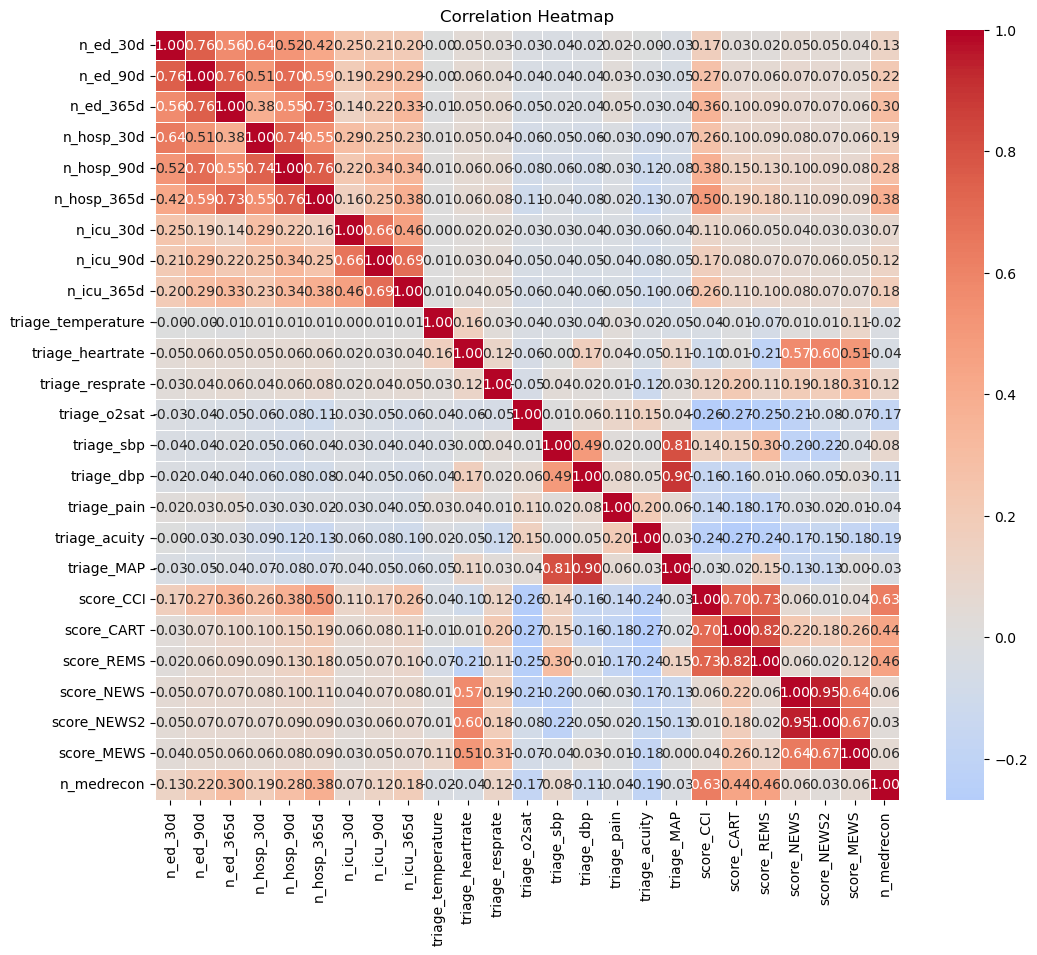

In [26]:
#NYX
import seaborn as sns
import matplotlib.pyplot as plt

# Create the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [27]:
# Calculate the correlation matrix using Spearman's rank correlation
correlation_matrix_spearman, _ = spearmanr(X_train_b_num)

# Set the threshold for correlation coefficient (absolute value)
threshold = 0.85

# Create a list to store significant variable pairs
significant_pairs = []

# Iterate through the correlation matrix and identify significant pairs
for i, var1 in enumerate(X_train_b_num.columns):
    for j, var2 in enumerate(X_train_b_num.columns):
        if i < j:  # To avoid duplicate pairs and correlations with themselves
            correlation = correlation_matrix_spearman[i, j]
            if abs(correlation) > threshold:
                significant_pairs.append((var1, var2, correlation))

# Convert the list of significant pairs into a DataFrame
significant_pairs_df = pd.DataFrame(significant_pairs, columns=['Variable 1', 'Variable 2', 'Correlation'])

# Display the significant pairs with correlation coefficient value > 0.85
print(significant_pairs_df)

   Variable 1   Variable 2  Correlation
0  triage_dbp   triage_MAP     0.895054
1  score_NEWS  score_NEWS2     0.945412


In [28]:
# We will drop truage_dbp and score_NEWS2 given their high correlation scores
# Retain NEWS instead of NEWS2 as the AUROC and AUPRC scores are better for NEWS based on the sample codes
correlated_features = ['triage_dbp','score_NEWS2']

X_train_b = X_train_b.drop(columns = correlated_features)
X_test_b = X_test_b.drop(columns = correlated_features)

In [29]:
print(X_train_b.columns.to_list())
print(len(X_train_b.columns.to_list()))

['n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d', 'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d', 'triage_temperature', 'triage_heartrate', 'triage_resprate', 'triage_o2sat', 'triage_sbp', 'triage_pain', 'triage_acuity', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness', 'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia', 'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1', 'cci_DM1', 'cci_DM2', 'cci_Paralysis', 'cci_Renal', 'cci_Cancer1', 'cci_Liver2', 'cci_Cancer2', 'cci_HIV', 'eci_Arrhythmia', 'eci_Valvular', 'eci_PHTN', 'eci_HTN1', 'eci_HTN2', 'eci_NeuroOther', 'eci_Hypothyroid', 'eci_Lymphoma', 'eci_Coagulopathy', 'eci_Obesity', 'eci_WeightLoss', 'eci_FluidsLytes', 'eci_BloodLoss', 'eci_Anemia', 'eci_Alcohol', 'eci_Drugs', 'eci_Psychoses', 'eci_Depression', '

(ii) With MinMaxScaler

In [31]:
# List the numerical variables which require scaling, excluding those highly correlated variables
num_features = [var for var in num_features if var not in correlated_features]

# instantiate MinMaxScaler to normalise the numeric fields
minmax_b = MinMaxScaler()
minmax_b.fit(X_train_b[num_features])

# Feature scaling for train set
feature_scaling_train_b = pd.DataFrame(minmax_b.transform(X_train_b[num_features]))
feature_scaling_train_b.columns = num_features
X_train_b = X_train_b.drop(columns = num_features) # drop original columns
X_train_b = X_train_b.join(feature_scaling_train_b) # join dfs together

# Feature scaling for test set
feature_scaling_test_b = pd.DataFrame(minmax_b.transform(X_test_b[num_features]))
feature_scaling_test_b.columns = num_features
X_test_b = X_test_b.drop(columns = num_features) # drop original columns
X_test_b = X_test_b.join(feature_scaling_test_b) # join dfs together

In [32]:
# Check the shape of the datasets
print(X_train_b.shape)
print(X_test_b.shape)
print(y_train_b.shape)
print(y_test_b.shape)

(273032, 106)
(68258, 106)
(273032,)
(68258,)


(ii) With RobustScaler

In [33]:
# instantiate MinMaxScaler to normalise the numeric fields
robust_b = RobustScaler()
robust_b.fit(X_train_b[num_features])

# Feature scaling for train set
feature_scaling_train_b_ii = pd.DataFrame(robust_b.transform(X_train_b[num_features]))
feature_scaling_train_b_ii.columns = num_features
X_train_b_ii = X_train_b.drop(columns = num_features) # drop original columns
X_train_b_ii = X_train_b_ii.join(feature_scaling_train_b_ii) # join dfs together

# Feature scaling for test set
feature_scaling_test_b_ii = pd.DataFrame(robust_b.transform(X_test_b[num_features]))
feature_scaling_test_b_ii.columns = num_features
X_test_b_ii = X_test_b.drop(columns = num_features) # drop original columns
X_test_b_ii = X_test_b_ii.join(feature_scaling_test_b_ii) # join dfs together

In [34]:
# Check the shape of the datasets
print(X_train_b_ii.shape)
print(X_test_b_ii.shape)

(273032, 106)
(68258, 106)


### 5.  Modeling

#### a. Logistic Regression

In [35]:
# Containers for all results
result_list = []

(i) Base Model as per sample codes

Logistic Regression:


C:\Users\NYX\anaconda3\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 3.6698715686798096 seconds
AUC: 0.8027248433401966
AUPRC: 0.7675283805362425
Sensitivity: 0.7397820163487738
Specificity: 0.7210110672376397
Score thresold: 0.4472618208502355
2.5 97.5


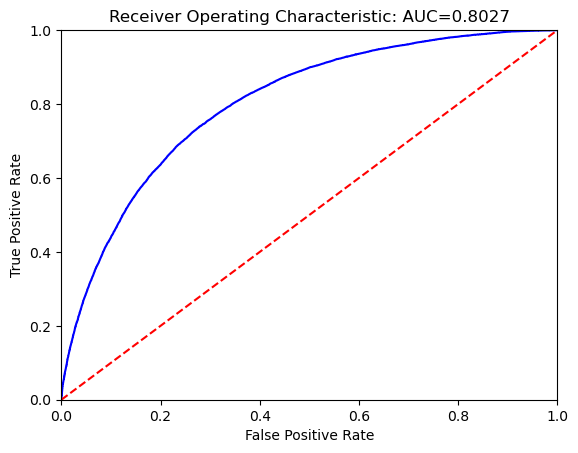

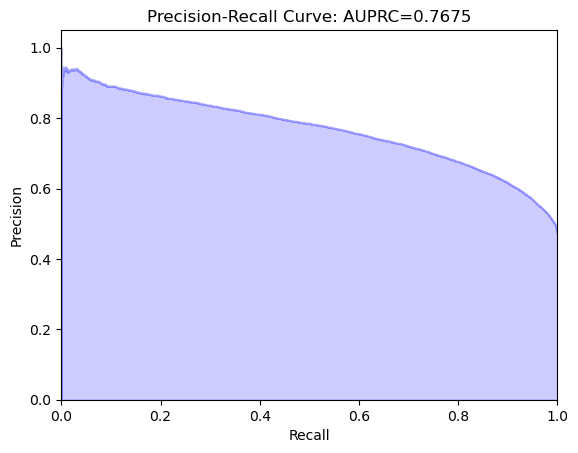

In [36]:
print("Logistic Regression:") #0.806 , 0.8027, 0.8027
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=1234)
start = time.time()
logreg.fit(X_train_default,y_train_default)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test_default)
result = PlotROCCurve(probs[:,1],y_test_default, ci=confidence_interval)

results = ["LR_base"]
results.extend(result)
results.append(runtime)
result_list.append(results)

(ii) Base variables but applied one-hot encoding on "gender" and feature scale numeric variables

Logistic Regression:


C:\Users\NYX\anaconda3\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 3.871697187423706 seconds
AUC: 0.798415537245112
AUPRC: 0.7634127517910351
Sensitivity: 0.7371501114689125
Specificity: 0.7140314776708748
Score thresold: 0.44818674873673653
2.5 97.5


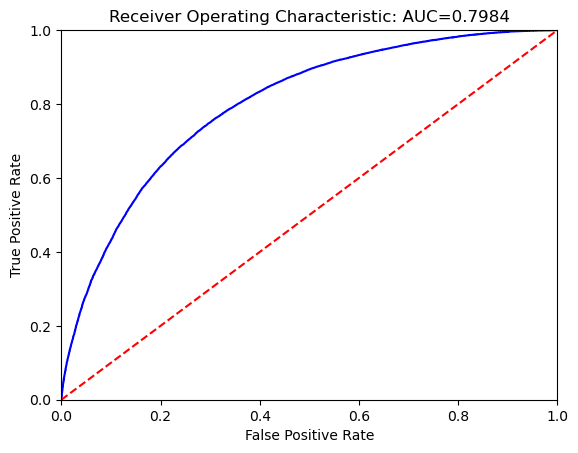

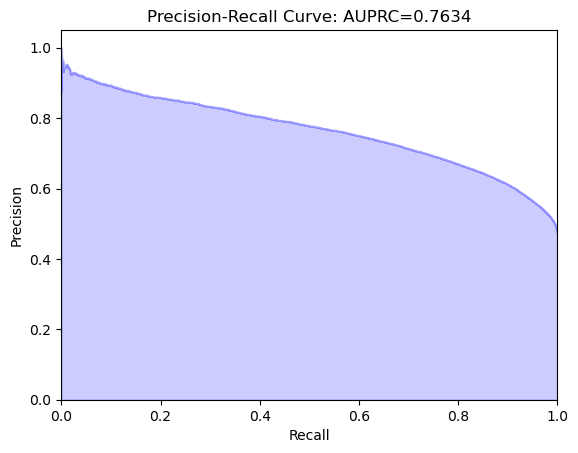

In [37]:
print("Logistic Regression:") # 0.801, 0.7984, 0.7984

# Included Hyperparameters as indicated in the reference paper
logreg=LogisticRegression(penalty='l2',C=1.0, max_iter=100,random_state=1234)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR_base_variables_with_features_scaling"]
results.extend(result)
results.append(runtime)
result_list.append(results)



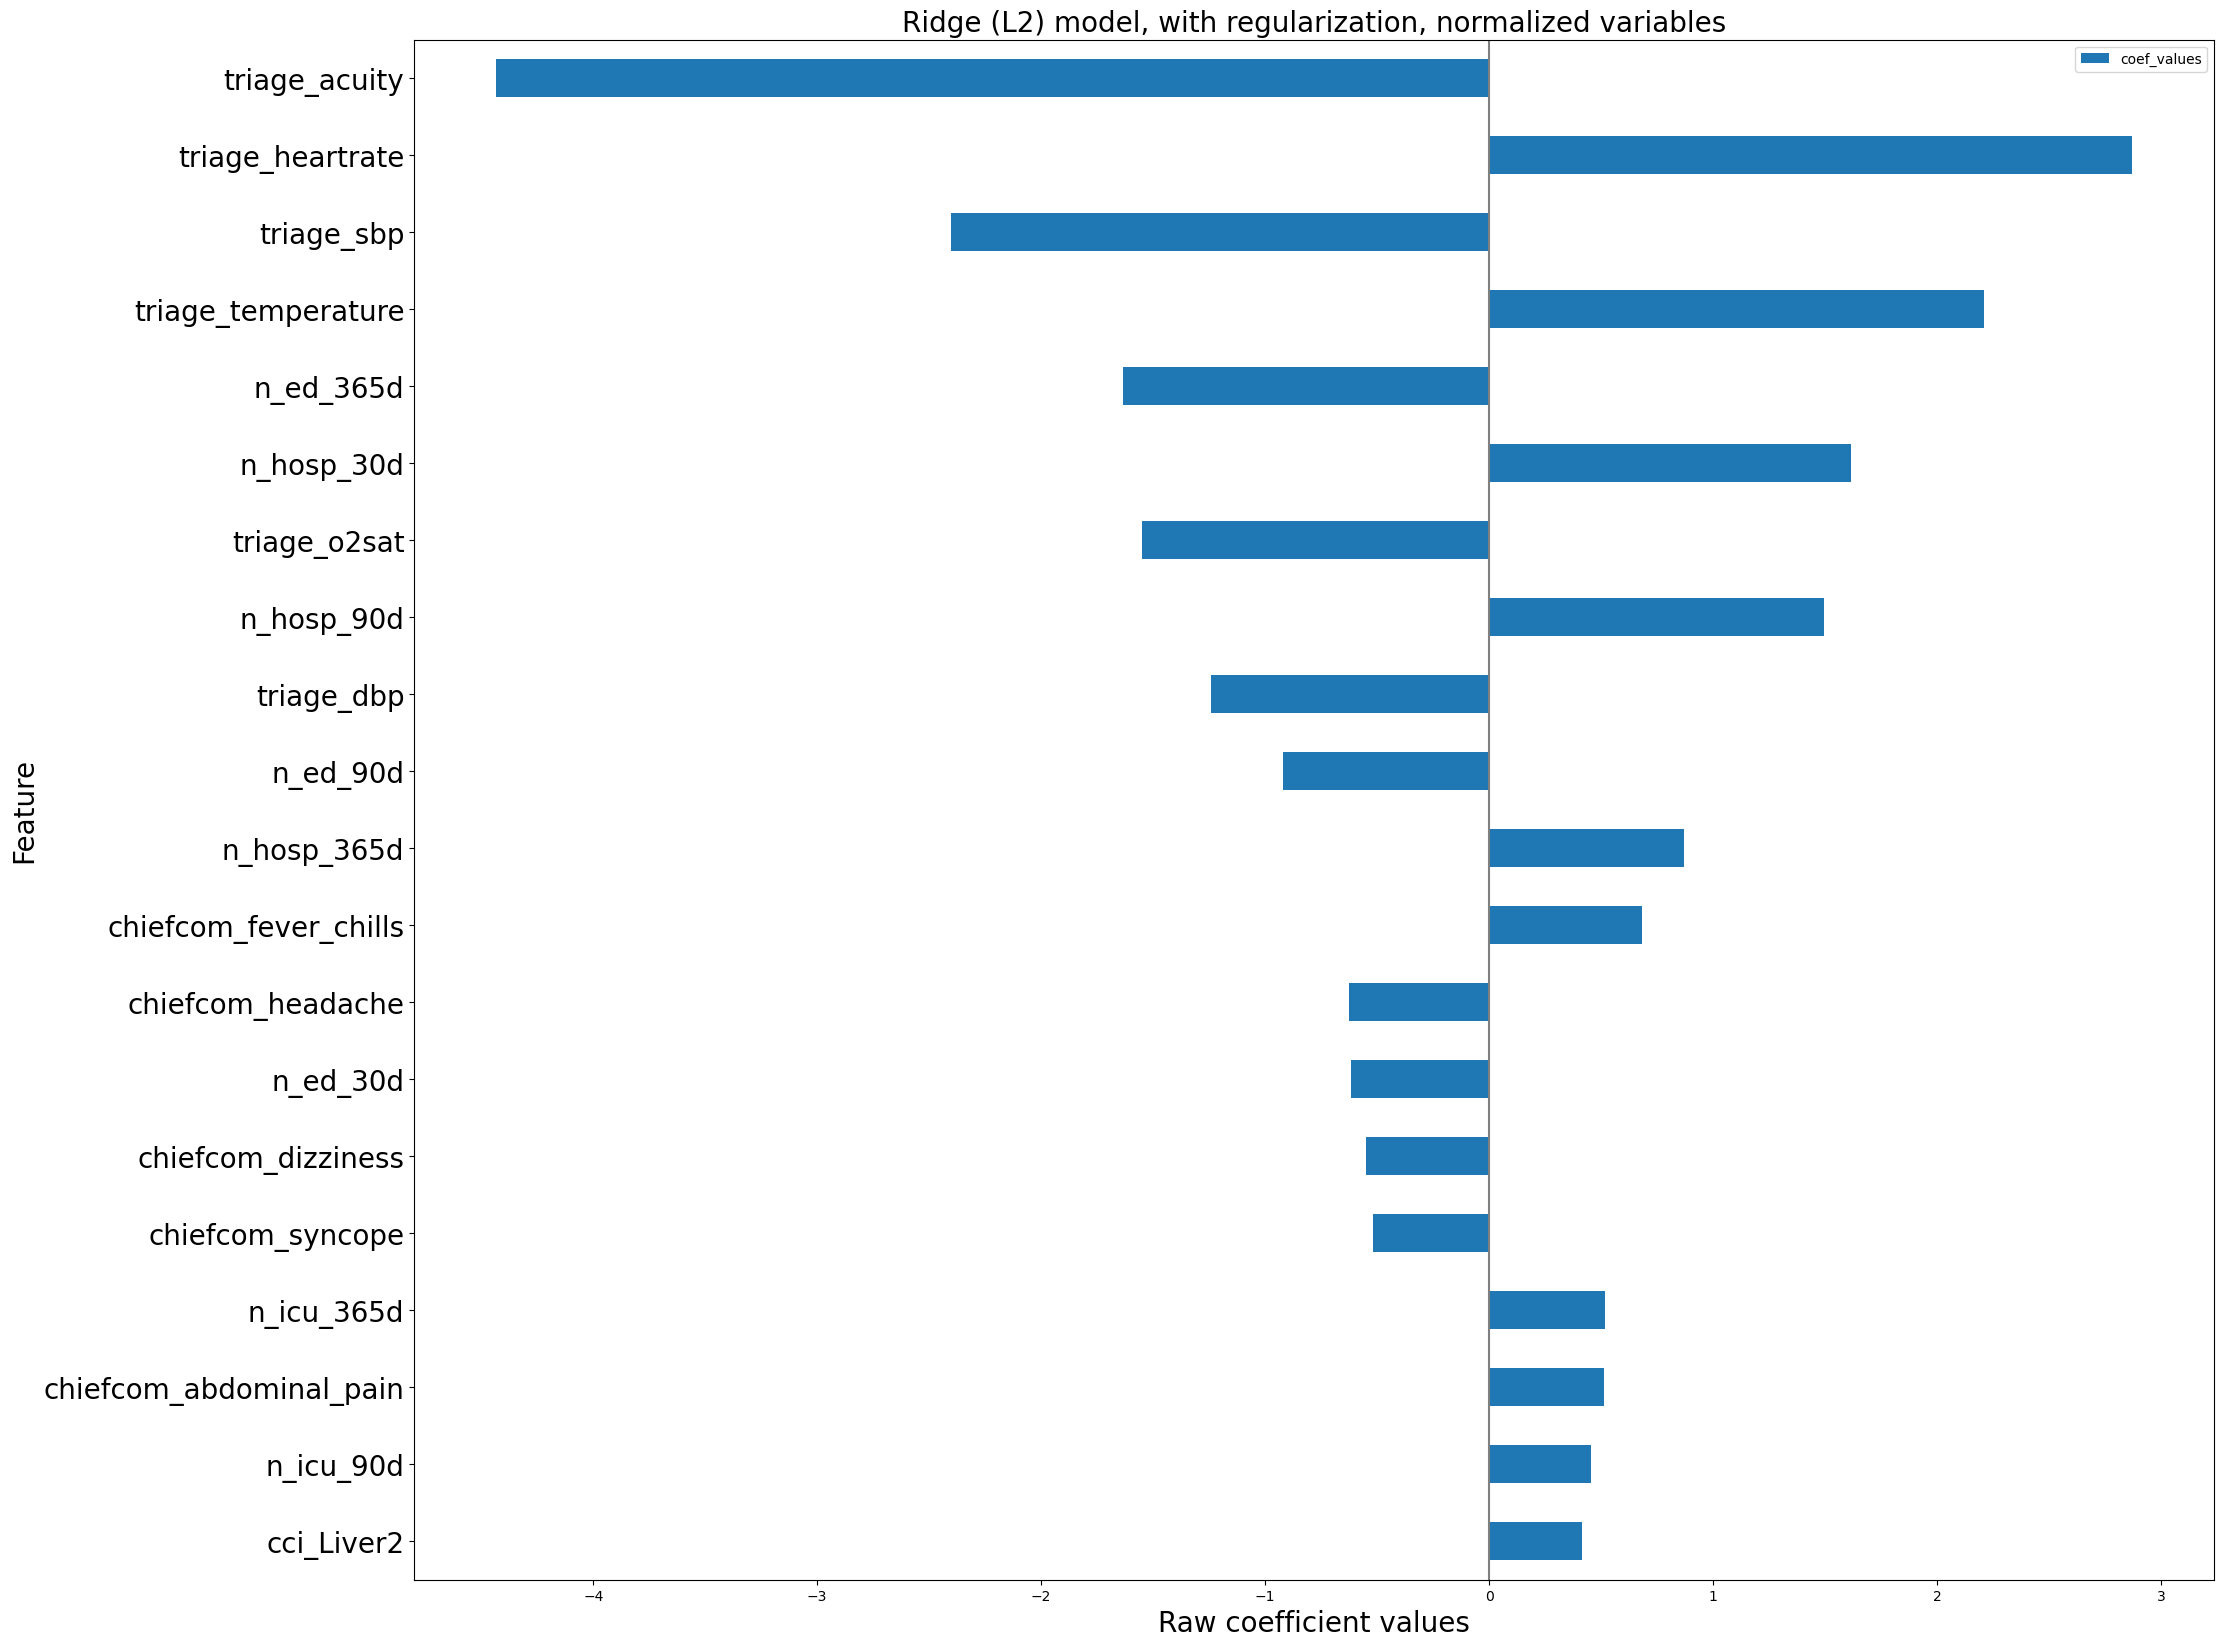

In [38]:
# Feature importance for LR model
logreg_coef = pd.DataFrame(
        {
            'features': np.array(X_train.columns),    
            'coef_values' : logreg.coef_.reshape(-1)
            })

sorted_coef = logreg_coef.sort_values(by='coef_values',key=lambda x:abs(x),ascending=False)[:20].set_index('features')

sorted_coef.sort_values(by='coef_values',key=lambda x:abs(x)).plot.barh(figsize=(30, 20))
plt.title("Ridge (L2) model, with regularization, normalized variables", fontsize=20)
plt.xlabel("Raw coefficient values", fontsize=20)
plt.ylabel('Feature',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

(iii) Additional variables (with MinMaxScaling for Numerical Variable)

Logistic Regression:


C:\Users\NYX\anaconda3\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 3.9964287281036377 seconds
AUC: 0.8072416120106523
AUPRC: 0.7746379704765136
Sensitivity: 0.7420733217735943
Specificity: 0.7259885434625438
Score thresold: 0.4508383479561814
2.5 97.5


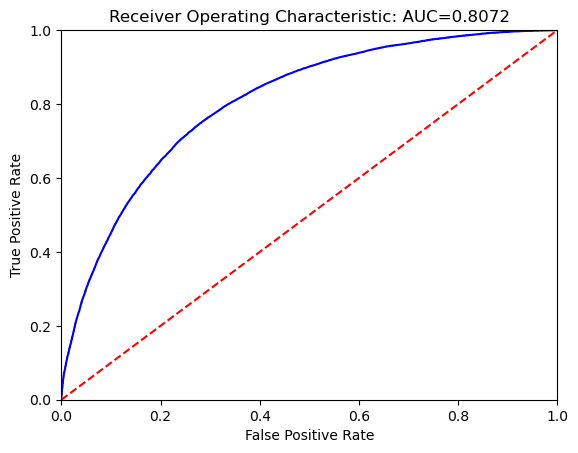

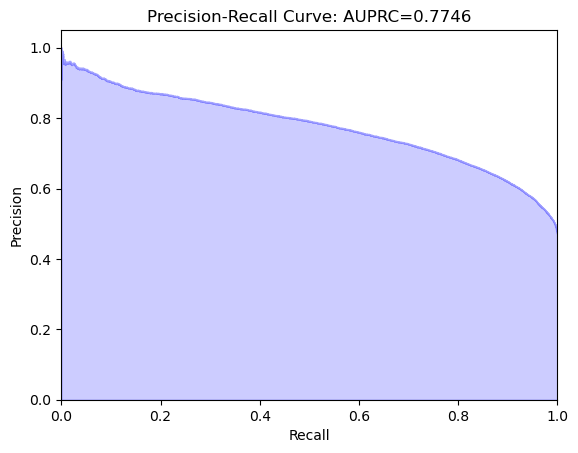

In [39]:
print("Logistic Regression:") # 0.814, 0.8067 (bin by med), 0.8072 (bin by 5)

# Included Hyperparameters as indicated in the reference paper
logreg_b=LogisticRegression(penalty='l2',C=1.0, max_iter=100, random_state=1234)
start = time.time()
logreg_b.fit(X_train_b,y_train_b)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs_b = logreg_b.predict_proba(X_test_b)
result = PlotROCCurve(probs_b[:,1],y_test_b, ci=confidence_interval)

results = ["LR_add_variables_with_MinMax"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [40]:
# Feature importance for LR model
logreg_coef_b = pd.DataFrame(
        {
            'features': np.array(X_train_b.columns),    
            'coef_values' : logreg_b.coef_.reshape(-1)
            })

# Check top 20 features
logreg_coef_b.sort_values(by='coef_values',key=lambda x:abs(x),ascending=False)[:20]

,features,coef_values
85,n_ed_365d,-6.655206
87,n_hosp_90d,5.558650
92,triage_temperature,5.426288
88,n_hosp_365d,5.236239
95,triage_o2sat,-4.994404
98,triage_acuity,-4.312105
86,n_hosp_30d,4.121862
84,n_ed_90d,-3.367391
83,n_ed_30d,-2.087999
73,"age_binned_[98.0, inf)",2.082673


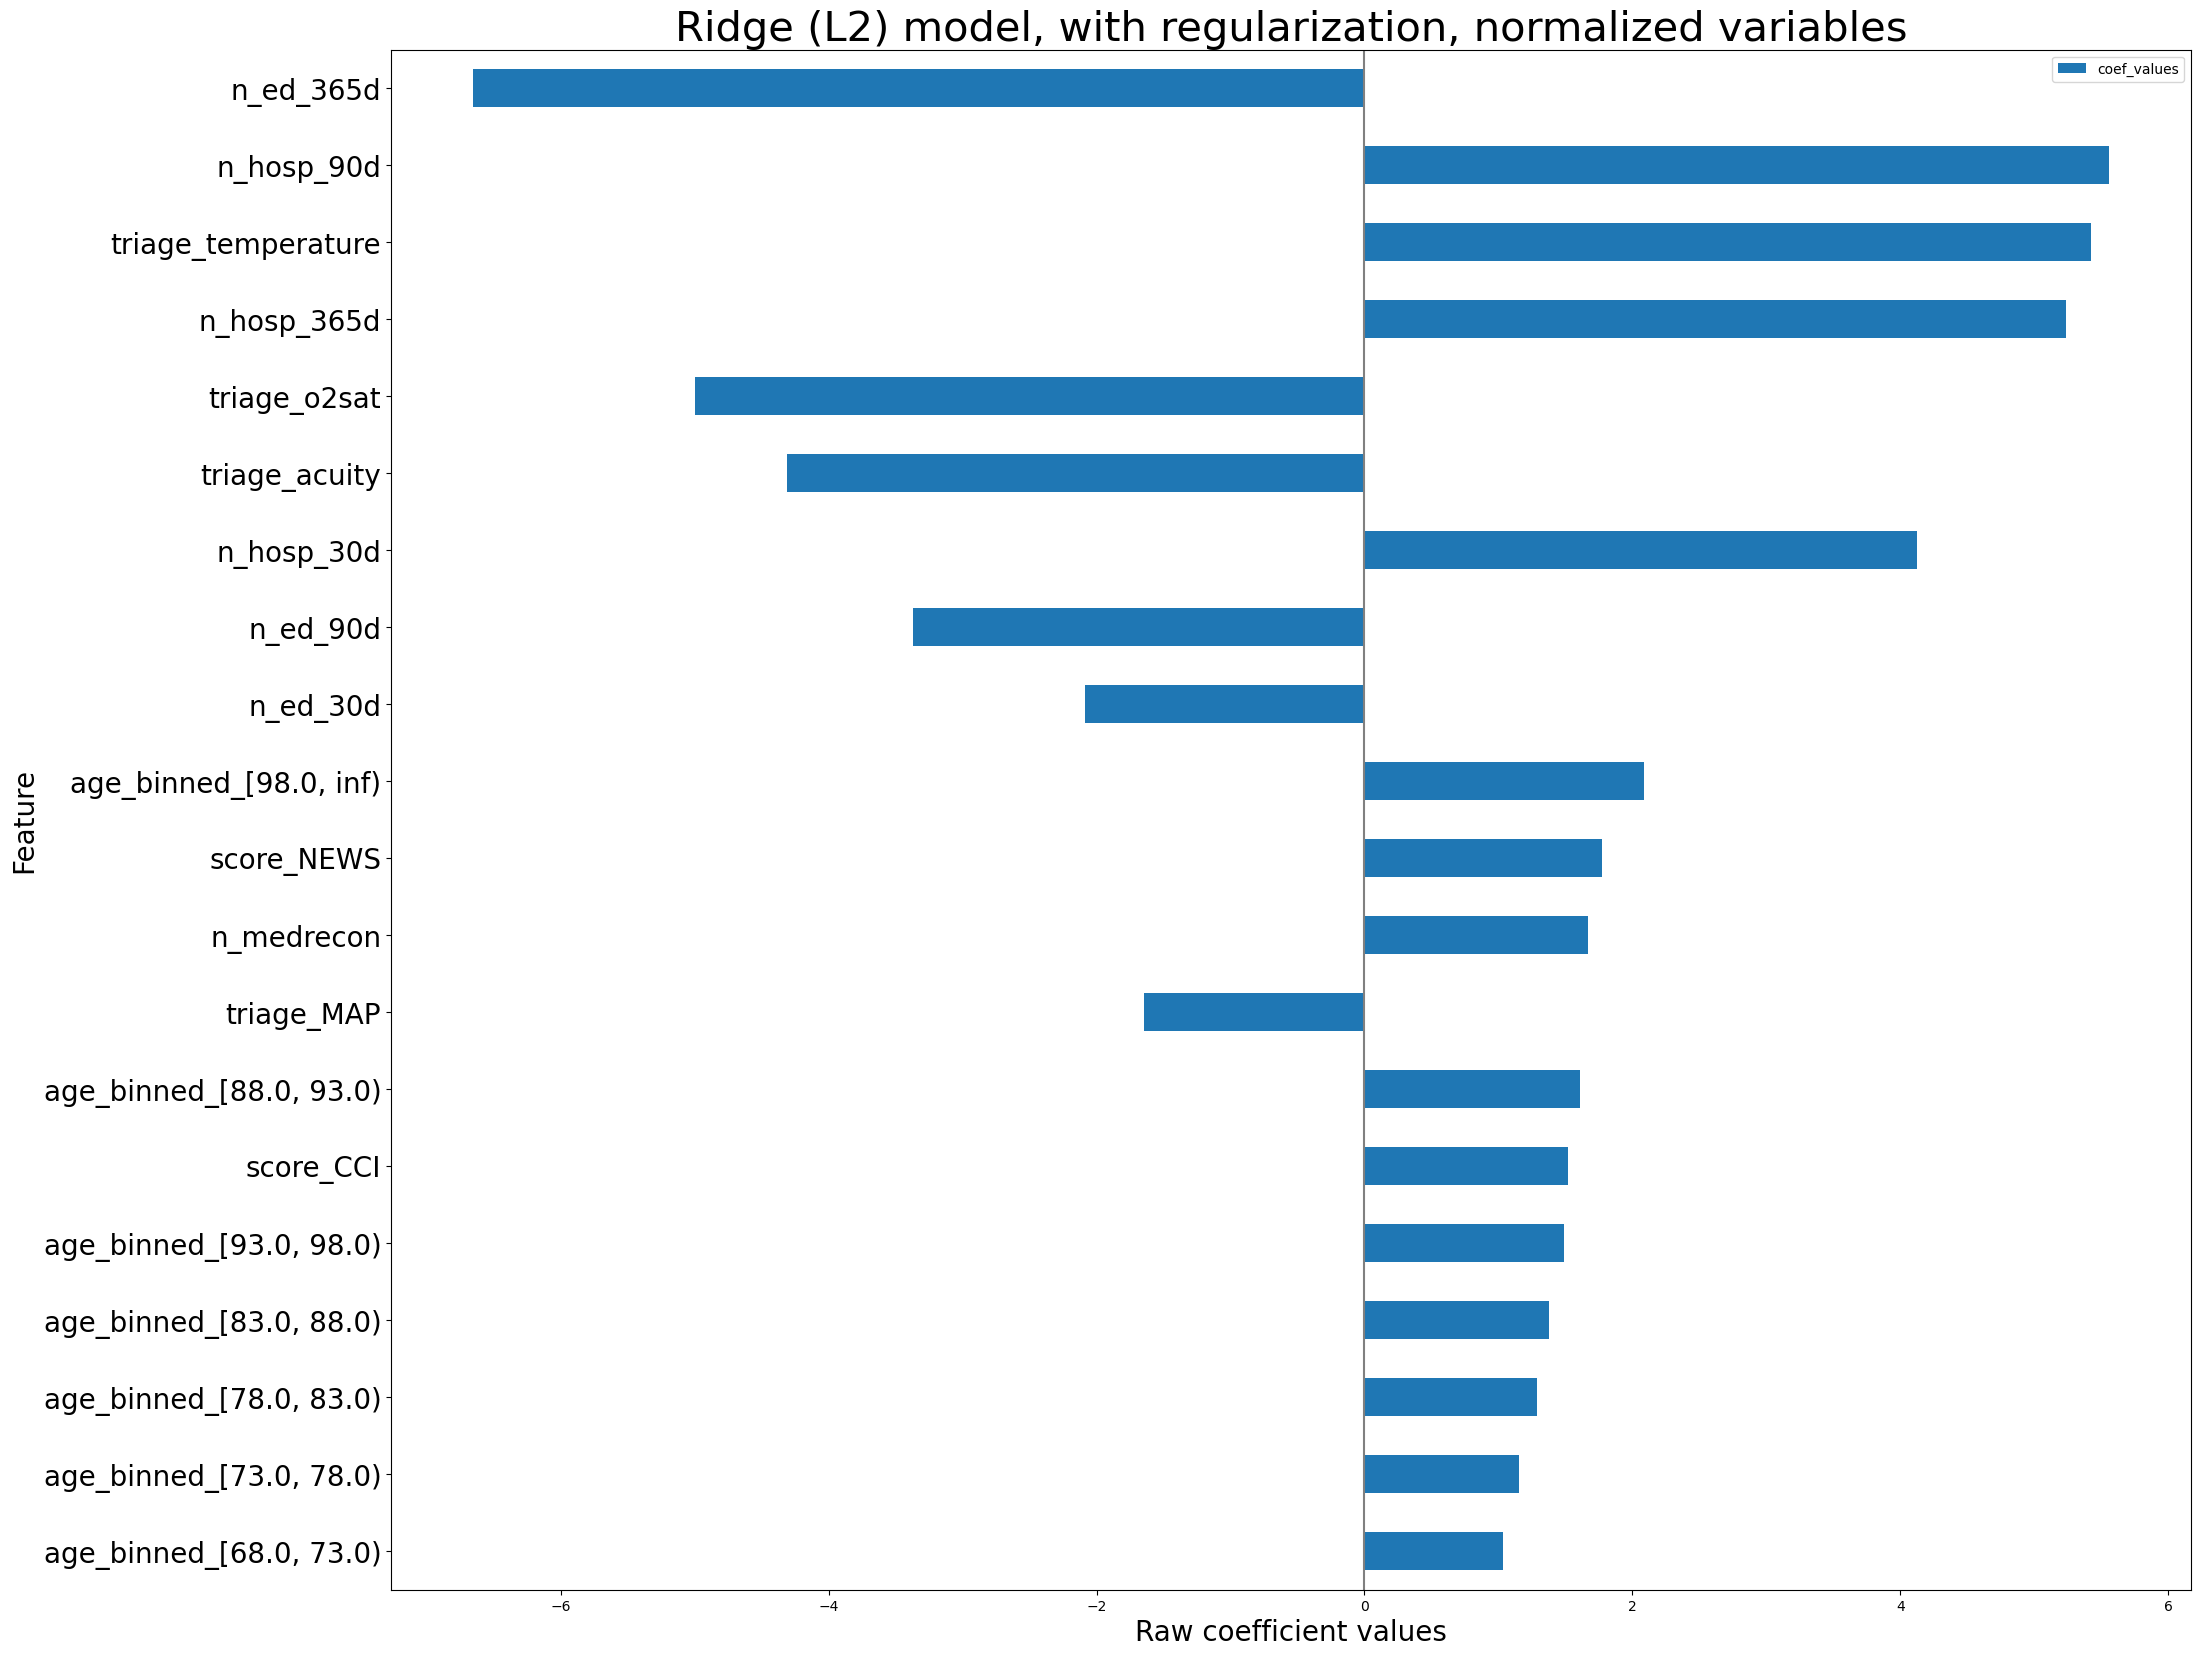

In [41]:
# Plot feature importance bar chart

sorted_coef_b = logreg_coef_b.sort_values(by='coef_values',key=lambda x:abs(x),ascending=False)[:20].set_index('features')

sorted_coef_b.sort_values(by='coef_values',key=lambda x:abs(x)).plot.barh(figsize=(30, 20))
plt.title("Ridge (L2) model, with regularization, normalized variables", fontsize=30)
plt.xlabel("Raw coefficient values", fontsize=20)
plt.ylabel('Feature',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

(iv) Additional variables with RobustScaling for Numerical Variables

Logistic Regression:


C:\Users\NYX\anaconda3\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 4.05194616317749 seconds
AUC: 0.8086345575505435
AUPRC: 0.7756378776057891
Sensitivity: 0.7431260837255388
Specificity: 0.7270174072632223
Score thresold: 0.4508326099771519
2.5 97.5


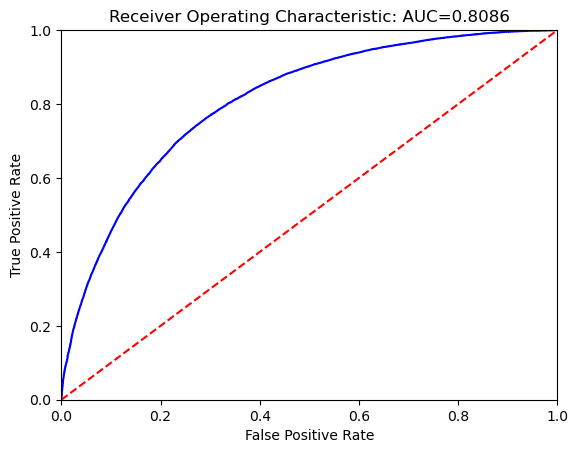

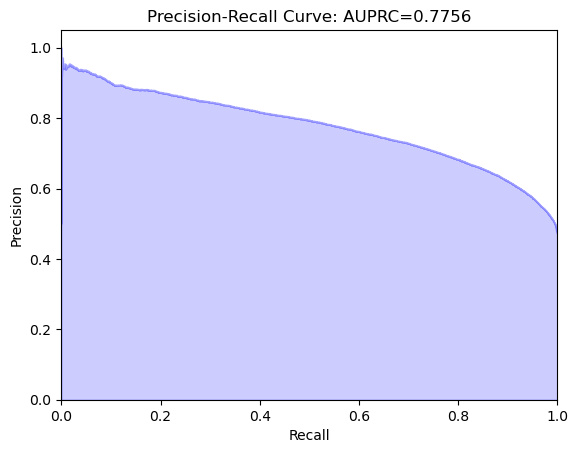

In [42]:
print("Logistic Regression:") # 0.814, 0.8083, 0.8086


# Included Hyperparameters as indicated in the reference paper
logreg_b_ii=LogisticRegression(penalty='l2',C=1.0, max_iter=100, random_state=1234)
start = time.time()
logreg_b_ii.fit(X_train_b_ii,y_train_b)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs_b_ii = logreg_b_ii.predict_proba(X_test_b_ii)
result = PlotROCCurve(probs_b_ii[:,1],y_test_b, ci=confidence_interval)

results = ["LR_add_variables_with_RobustScaler"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [70]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
# formatted_result_df.to_csv(os.path.join(path, 'age_bin_equal_LR.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR_base,0.447,0.803 (0.8-0.805),0.768 (0.762-0.77),0.74 (0.73-0.745),0.721 (0.719-0.733),3.670
1,LR_base_variables_with_features_caling,0.448,0.798 (0.795-0.801),0.763 (0.758-0.766),0.737 (0.724-0.744),0.714 (0.706-0.73),3.872
2,LR_add_variables_with_MinMax,0.451,0.807 (0.805-0.81),0.775 (0.77-0.777),0.742 (0.731-0.756),0.726 (0.715-0.741),3.996
3,LR_add_variables_with_RobustScaler,0.451,0.809 (0.806-0.811),0.776 (0.771-0.778),0.743 (0.734-0.753),0.727 (0.717-0.738),4.052


(v) Conduct Hyerparameter tuning

In [20]:
# Warning: Tuning takes about 4.5hrs!!

print("Logistic Regression:")
# Setup hyperparameters for tuning
params_grid = {
    'penalty': ['l1', 'l2','elasticnet'],
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [300, 400]
}


# Instantiate the logreg model
logreg_tuning = LogisticRegression(random_state=1234)

# Time and run the gridsearch
start = time.time()
grid_search = GridSearchCV(logreg_tuning, params_grid, scoring='roc_auc', refit=True, cv=5, n_jobs=-1,verbose = 3)
grid_search.fit(X_train_b, y_train_b)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')

Logistic Regression:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
480 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Va

Training time: 16459.584407806396 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [21]:
# generate best params
grid_search.best_params_

{'C': 100.0, 'max_iter': 400, 'penalty': 'l1', 'solver': 'saga'}

In [22]:
# assign the best estimator to to log_reg_tuned
logreg_tuned = grid_search.best_estimator_
logreg_tuned

LogisticRegression(C=100.0, max_iter=400, penalty='l1', random_state=1234,
                   solver='saga')

In [27]:
# Save the tuned model
pickle.dump(logreg_tuned, open('logreg_tuned.pkl', 'wb'))

In [ ]:
# load the tuned model
# logreg_tuned = pickle.load(open('logreg_tuned.pkl', 'rb'))

Logistic Regression:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training time: 193.04284715652466 seconds
AUC: 0.8149683206383723
AUPRC: 0.788421703790195
Sensitivity: 0.7460332701217024
Specificity: 0.7317519033076691
Score thresold: 0.45506488172340176
2.5 97.5


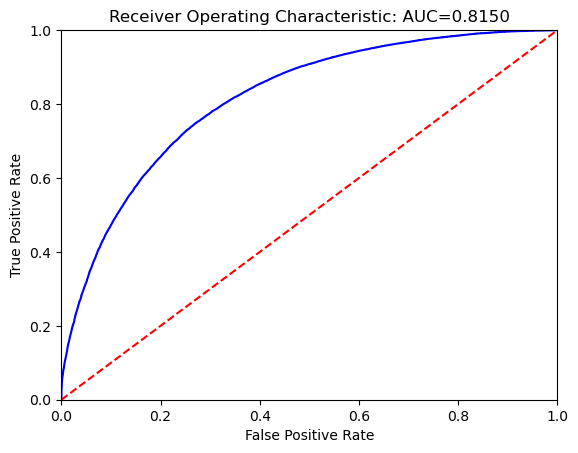

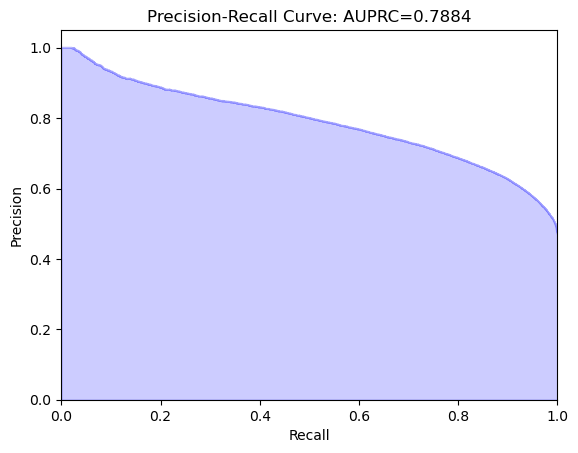

In [122]:
# Generate results for the tuned model
print("Logistic Regression:")

# Included Hyperparameters as indicated in the reference paper
start = time.time()
logreg_tuned.fit(X_train_b,y_train_b)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')

probs_b_tuned = logreg_tuned.predict_proba(X_test_b)
result = PlotROCCurve(probs_b_tuned[:,1],y_test_b, ci=confidence_interval)

results = ["LR_tuned_with_MinMaxScaling"]
results.extend(result)
results.append(runtime)
result_list.append(results)

(vi) Performance Output for LogReg modelling

In [123]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
#formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR_base,0.443,0.806 (0.804-0.809),0.774 (0.768-0.776),0.746 (0.728-0.754),0.718 (0.712-0.732),6.074
1,LR_base_variables_with_features_caling,0.460,0.801 (0.798-0.804),0.768 (0.762-0.77),0.731 (0.726-0.749),0.72 (0.702-0.726),6.835
2,LR_add_variables_with_MinMax,0.451,0.814 (0.812-0.817),0.786 (0.781-0.789),0.749 (0.737-0.751),0.728 (0.725-0.74),8.529
3,LR_add_variables_with_RobustScaler,0.465,0.814 (0.811-0.817),0.783 (0.778-0.786),0.734 (0.732-0.753),0.742 (0.722-0.743),8.536
4,LR_tuned_with_MinMaxScaling,0.455,0.815 (0.812-0.818),0.788 (0.784-0.791),0.746 (0.737-0.749),0.732 (0.728-0.739),193.043


In [124]:
# Ouput formmatted_result_df to csv
formatted_result_df.to_csv(os.path.join(path, 'result_hospitalization_triage_logreg.csv'), index=False)

## b. Random Forest

In [43]:
# Containers for all results
result_list_rf = []

(i) Base Model as per sample codes

RandomForest:
Training time: 84.14781999588013 seconds
AUC: 0.8114343500426792
AUPRC: 0.7761847238668582
Sensitivity: 0.7404012880852118
Specificity: 0.7317724264501418
Score thresold: 0.5
2.5 97.5


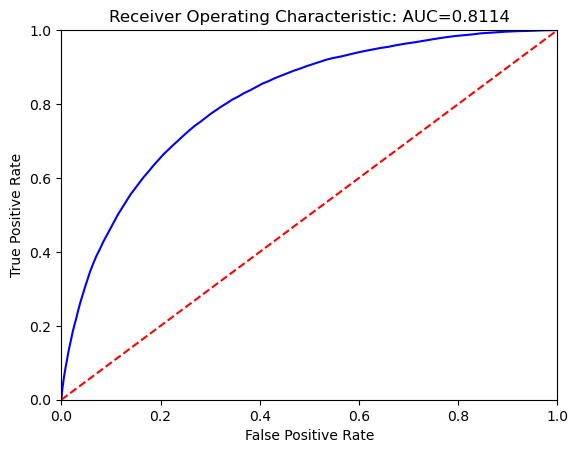

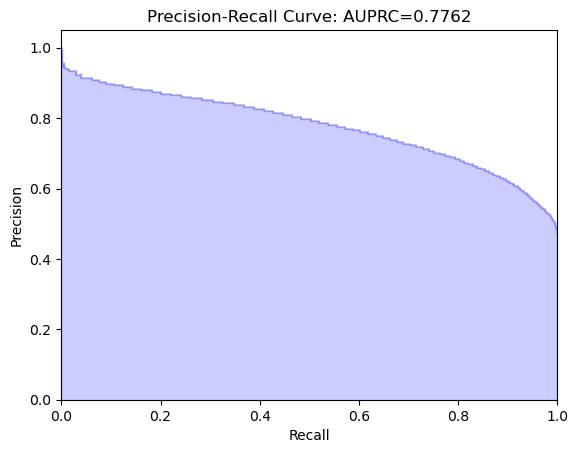

In [44]:
print("RandomForest:") # 0.819, 0.8114, 0.8114

rf= RandomForestClassifier(random_state=1234)
start = time.time()
rf.fit(X_train_default,y_train_default)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test_default)
result = PlotROCCurve(probs[:,1],y_test_default, ci=confidence_interval, random_seed=random_seed)

results = ["RF_base"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

(ii) Base variables but applied one-hot encoding on "gender" and feature scale numeric variables

RandomForest:
Training time: 86.53627014160156 seconds
AUC: 0.810978504603096
AUPRC: 0.7758162440596402
Sensitivity: 0.7402774337379242
Specificity: 0.73266225460208
Score thresold: 0.5
2.5 97.5


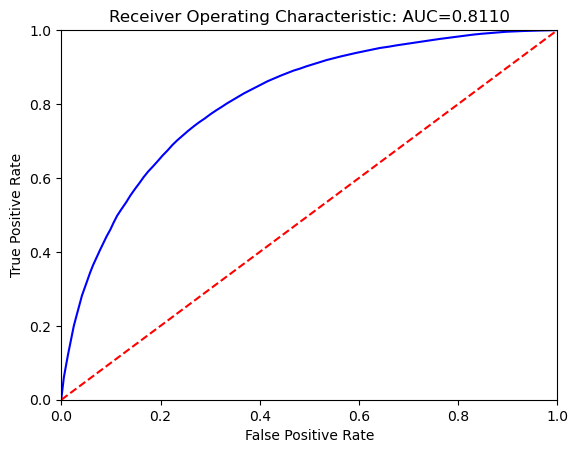

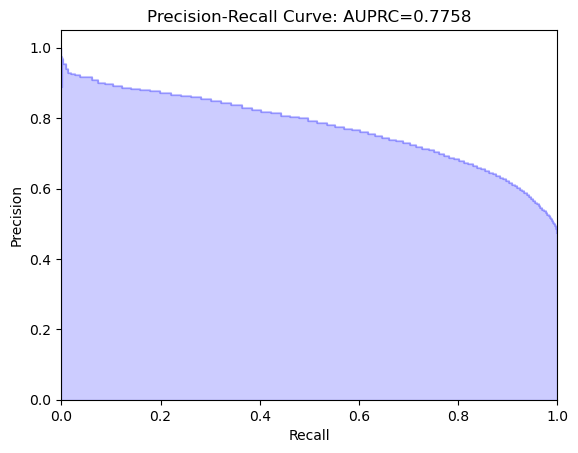

In [45]:
print("RandomForest:") # 0.82, 0.8117, 0.8110

rf= RandomForestClassifier(random_state=1234)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["RF_base_variables_with_features_caling"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

(iii) Additional variables (with MinMaxScaling for Numerical Variable)

RandomForest:
Training time: 122.07852339744568 seconds
AUC: 0.8131559317553385
AUPRC: 0.7773235141302853
Sensitivity: 0.749102055982165
Specificity: 0.7292419776430676
Score thresold: 0.49
2.5 97.5


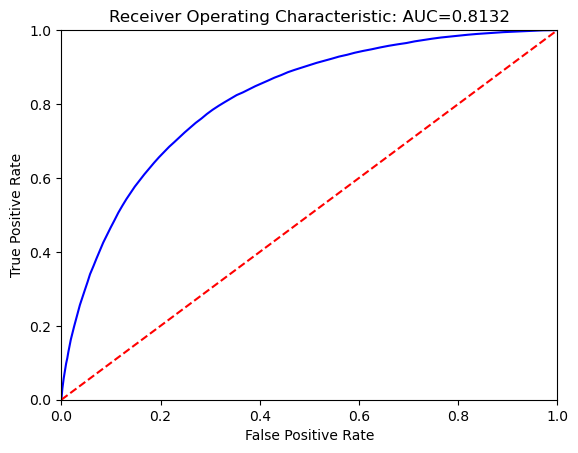

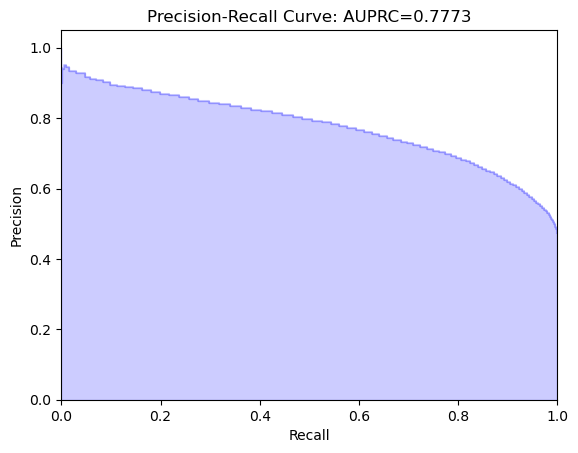

In [46]:
print("RandomForest:") # 0.821, 0.8125, 0.8132

rf_b= RandomForestClassifier(random_state=1234)
start = time.time()
rf_b.fit(X_train_b,y_train_b)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs_b = rf_b.predict_proba(X_test_b)
result = PlotROCCurve(probs_b[:,1],y_test_b, ci=confidence_interval, random_seed=random_seed)

results = ["RF_add_variables_with_MinMax"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

(iv) Additional variables with RobustScaling for Numerical Variables

RandomForest:
Training time: 102.93453216552734 seconds
AUC: 0.813109043816749
AUPRC: 0.7773457892419358
Sensitivity: 0.7494736190240278
Specificity: 0.7292141705133196
Score thresold: 0.49
2.5 97.5


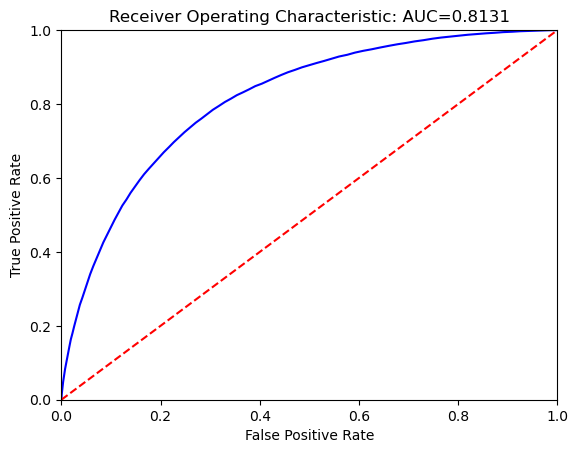

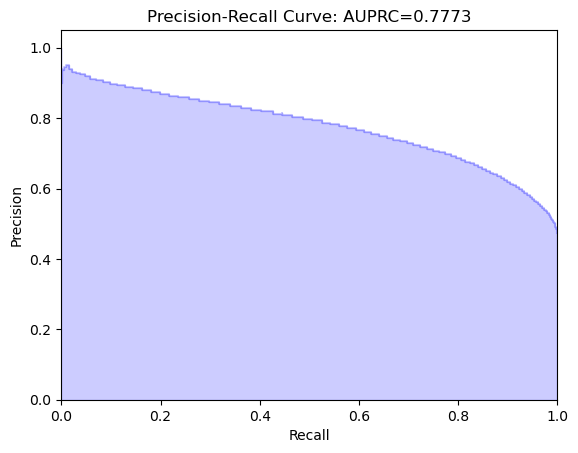

In [47]:
print("RandomForest:") # 0.821, 0.8126, 0.8131

rf_b_ii = RandomForestClassifier(random_state=1234)
start = time.time()
rf_b_ii.fit(X_train_b_ii,y_train_b)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs_b_ii = rf_b_ii.predict_proba(X_test_b_ii)
result = PlotROCCurve(probs_b_ii[:,1],y_test_b, ci=confidence_interval, random_seed=random_seed)

results = ["RF_add_variables_with_RobustScaler"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

In [72]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_rf, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
#formatted_result_df.to_csv(os.path.join(path, 'age_bin_equal_RF.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,RF_base,0.50,0.811 (0.809-0.815),0.776 (0.771-0.78),0.74 (0.736-0.745),0.732 (0.728-0.741),84.148
1,RF_base_variables_with_features_caling,0.50,0.811 (0.809-0.814),0.776 (0.772-0.779),0.74 (0.729-0.752),0.733 (0.721-0.743),86.536
2,RF_add_variables_with_MinMax,0.49,0.813 (0.809-0.816),0.777 (0.772-0.78),0.749 (0.742-0.77),0.729 (0.713-0.736),122.079
3,RF_add_variables_with_RobustScaler,0.49,0.813 (0.809-0.816),0.777 (0.772-0.78),0.749 (0.741-0.753),0.729 (0.725-0.737),102.935


In [42]:
# Print hyperparameters used in the current model
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}


(v) Conduct Hyerparameter tuning

Parameters to tune:

- n_estimators: [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
- min_samples_split: [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] #min. # of samples required to split an internal node
- min_samples_leaf: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] #min. # of samples required to be at a leaf node.
- criterion: ['gini', 'entropy']
- max_features: ['sqrt', 'log2'] # number of features to consider when looking for the best split.
- max_depth: [20, 40, 60, 80, 100, None]
- bootstrap: [True, False]
- max_samples: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

<br>References: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [33]:
# Number of trees 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.insert(0, 100)

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Criterion
criterion = ['gini', 'entropy']

# Number of features to consider at every split
max_features = ['sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Max Samples
max_samples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, None]

In [44]:
# # First create the base model to tune
# rf_tuning = RandomForestClassifier()
# # Random search of parameters, using 5 fold cross validation, 
# # search across 10 different combinations, and use all available cores
# # Time and run the random search

# start = time.time()
# rf_random = RandomizedSearchCV(estimator = rf_tuning, param_distributions = random_grid, scoring='roc_auc', n_iter = 10, cv = 5, verbose=2, random_state=1234, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train_b,y_train_b)
# runtime = time.time()-start
# print('Training time:', runtime, 'seconds')


Fitting 5 folds for each of 10 candidates, totalling 50 fits


MemoryError: Unable to allocate 103. MiB for an array with shape (48, 282103) and data type float64

#### Tuning: min_samples_leaf and min_samples_split

In [34]:
# Create the parameters for tuning
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}

print(param_grid)

# Instantiate Random Forest Model
rf = RandomForestClassifier(random_state=random_seed)

# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
rf_grid.fit(X_train_b,y_train_b)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

rf_grid_results = pd.DataFrame(rf_grid.cv_results_)

print('Best Score: ', rf_grid.best_score_) 
print('Best Params: ', rf_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
rf_grid_results["mean_roc_auc"] = rf_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rf_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True)

{'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], 'min_samples_split': [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]}
Fitting 5 folds for each of 110 candidates, totalling 550 fits
Grid Search Tuning time: 34529.46139502525 seconds
Best Score:  0.8250482800875103
Best Params:  {'min_samples_leaf': 2, 'min_samples_split': 32}


,param_min_samples_leaf,param_min_samples_split,mean_roc_auc,rank_test_score
0,2,32,0.825048,1
1,1,32,0.824907,2
2,2,16,0.824793,3
3,4,32,0.824727,4
4,2,64,0.824708,5
...,...,...,...,...
105,1024,32,0.803219,101
106,1024,64,0.803219,101
107,1024,128,0.803219,101
108,1024,256,0.803219,101


In [47]:
# Replace tuned parameter(s) with best value
min_samples_leaf = [] 
min_samples_leaf.append(rf_grid.best_params_['min_samples_leaf'])

min_samples_split = [] 
min_samples_split.append(rf_grid.best_params_['min_samples_split'])

min_samples_leaf, min_samples_split

([2], [32])

#### Tuning: n_estimators

In [49]:
# Create the parameters for tuning
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'n_estimators': n_estimators}

print(param_grid)

# Instantiate Random Forest Model
rf = RandomForestClassifier(random_state=random_seed)

# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
rf_grid.fit(X_train_b,y_train_b)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

rf_grid_results = pd.DataFrame(rf_grid.cv_results_)

print('Best Score: ', rf_grid.best_score_) 
print('Best Params: ', rf_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
rf_grid_results["mean_roc_auc"] = rf_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rf_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True)

{'min_samples_leaf': [2], 'min_samples_split': [32], 'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Grid Search Tuning time: 35092.12586760521 seconds
Best Score:  0.8260543868957907
Best Params:  {'min_samples_leaf': 2, 'min_samples_split': 32, 'n_estimators': 2000}


,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_roc_auc,rank_test_score
0,2,32,2000,0.826054,1
1,2,32,1800,0.826047,2
2,2,32,1600,0.826041,3
3,2,32,1400,0.826025,4
4,2,32,1200,0.826006,5
5,2,32,1000,0.826006,6
6,2,32,800,0.825971,7
7,2,32,600,0.825885,8
8,2,32,400,0.825809,9
9,2,32,200,0.825505,10


In [50]:
# Replace tuned parameter(s) with best value
n_estimators = [] 
n_estimators.append(rf_grid.best_params_['n_estimators'])

n_estimators

[2000]

In [112]:
min_samples_leaf = [2]
min_samples_split = [32]
# Set n_estimators at 400 instead of 2000 to shorten the run time for grid search
n_estimators= [400]
# Bootstrap has to set to True in order to tune the max_samples parameter
bootstrap = [True]

#### Tuning: bootstrap, max_samples

In [113]:
# Create the parameters for tuning
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'n_estimators': n_estimators,
              'bootstrap': bootstrap,
              'max_samples': max_samples
             }

print(param_grid)

# Instantiate Random Forest Model
rf = RandomForestClassifier(random_state=random_seed)

# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
rf_grid.fit(X_train_b,y_train_b)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

rf_grid_results = pd.DataFrame(rf_grid.cv_results_)

print('Best Score: ', rf_grid.best_score_) 
print('Best Params: ', rf_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
rf_grid_results["mean_roc_auc"] = rf_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rf_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True)

{'min_samples_leaf': [2], 'min_samples_split': [32], 'n_estimators': [400], 'bootstrap': [True], 'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, None]}
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Grid Search Tuning time: 2471.7180573940277 seconds
Best Score:  0.8258094595424883
Best Params:  {'bootstrap': True, 'max_samples': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 32, 'n_estimators': 400}


,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_bootstrap,param_max_samples,mean_roc_auc,rank_test_score
0,2,32,400,True,1.0,0.825809,1
1,2,32,400,True,None,0.825809,1
2,2,32,400,True,0.9,0.825697,3
3,2,32,400,True,0.8,0.825593,4
4,2,32,400,True,0.7,0.825388,5
5,2,32,400,True,0.6,0.825126,6
6,2,32,400,True,0.5,0.824926,7
7,2,32,400,True,0.4,0.824535,8
8,2,32,400,True,0.3,0.823926,9
9,2,32,400,True,0.2,0.823085,10


In [114]:
# Replace tuned parameter(s) with best value
bootstrap = [] 
bootstrap.append(rf_grid.best_params_['bootstrap'])

max_samples = [] 
max_samples.append(rf_grid.best_params_['max_samples'])

bootstrap, max_samples

([True], [1.0])

#### Tuning: criterion

In [115]:
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'n_estimators': n_estimators,
              'bootstrap': bootstrap,
              'max_samples': max_samples,
              'criterion': criterion, 
             }

print(param_grid)

# Instantiate Random Forest Model
rf = RandomForestClassifier(random_state=random_seed)

# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
rf_grid.fit(X_train_b,y_train_b)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

rf_grid_results = pd.DataFrame(rf_grid.cv_results_)

print('Best Score: ', rf_grid.best_score_) 
print('Best Params: ', rf_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
rf_grid_results["mean_roc_auc"] = rf_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rf_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True)

{'min_samples_leaf': [2], 'min_samples_split': [32], 'n_estimators': [400], 'bootstrap': [True], 'max_samples': [1.0], 'criterion': ['gini', 'entropy']}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Grid Search Tuning time: 886.8021671772003 seconds
Best Score:  0.8266285143263618
Best Params:  {'bootstrap': True, 'criterion': 'entropy', 'max_samples': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 32, 'n_estimators': 400}


,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_bootstrap,param_max_samples,param_criterion,mean_roc_auc,rank_test_score
0,2,32,400,True,1.0,entropy,0.826629,1
1,2,32,400,True,1.0,gini,0.825809,2


In [116]:
# Replace tuned parameter(s) with best value
criterion = [] 
criterion.append(rf_grid.best_params_['criterion'])

criterion

['entropy']

#### Tuning: max_features

In [117]:
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'n_estimators': n_estimators,
              'bootstrap': bootstrap,
              'max_samples': max_samples,
              'criterion': criterion, 
              'max_features' : max_features
             }

print(param_grid)

# Instantiate Random Forest Model
rf = RandomForestClassifier(random_state=random_seed)

# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
rf_grid.fit(X_train_b,y_train_b)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

rf_grid_results = pd.DataFrame(rf_grid.cv_results_)

print('Best Score: ', rf_grid.best_score_) 
print('Best Params: ', rf_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
rf_grid_results["mean_roc_auc"] = rf_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rf_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True)

{'min_samples_leaf': [2], 'min_samples_split': [32], 'n_estimators': [400], 'bootstrap': [True], 'max_samples': [1.0], 'criterion': ['entropy'], 'max_features': ['sqrt', 'log2']}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Grid Search Tuning time: 807.5286376476288 seconds
Best Score:  0.8266285143263618
Best Params:  {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 32, 'n_estimators': 400}


,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_bootstrap,param_max_samples,param_criterion,param_max_features,mean_roc_auc,rank_test_score
0,2,32,400,True,1.0,entropy,sqrt,0.826629,1
1,2,32,400,True,1.0,entropy,log2,0.823966,2


In [118]:
# Replace tuned parameter(s) with best value

max_features = [] 
max_features.append(rf_grid.best_params_['max_features'])

max_features

['sqrt']

#### Tuning: max_depth

In [119]:
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'n_estimators': n_estimators,
              'bootstrap': bootstrap,
              'max_samples': max_samples,
              'criterion': criterion, 
              'max_features' : max_features,
              'max_depth' : max_depth
             }

print(param_grid)

# Instantiate Random Forest Model
rf = RandomForestClassifier(random_state=random_seed)

# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
rf_grid.fit(X_train_b,y_train_b)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

rf_grid_results = pd.DataFrame(rf_grid.cv_results_)

print('Best Score: ', rf_grid.best_score_) 
print('Best Params: ', rf_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
rf_grid_results["mean_roc_auc"] = rf_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rf_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True)

{'min_samples_leaf': [2], 'min_samples_split': [32], 'n_estimators': [400], 'bootstrap': [True], 'max_samples': [1.0], 'criterion': ['entropy'], 'max_features': ['sqrt'], 'max_depth': [20, 40, 60, 80, 100, None]}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Grid Search Tuning time: 2098.7231109142303 seconds
Best Score:  0.826644179013433
Best Params:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 32, 'n_estimators': 400}


,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_bootstrap,param_max_samples,param_criterion,param_max_features,param_max_depth,mean_roc_auc,rank_test_score
0,2,32,400,True,1.0,entropy,sqrt,40,0.826644,1
1,2,32,400,True,1.0,entropy,sqrt,60,0.826630,2
2,2,32,400,True,1.0,entropy,sqrt,80,0.826629,3
3,2,32,400,True,1.0,entropy,sqrt,100,0.826629,3
4,2,32,400,True,1.0,entropy,sqrt,None,0.826629,3
5,2,32,400,True,1.0,entropy,sqrt,20,0.824627,6


In [120]:
# Replace tuned parameter(s) with best value

max_depth = []
max_depth.append(rf_grid.best_params_['max_depth'])

max_depth

[40]

In [121]:
#Best Parameters
rf_grid.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 'sqrt',
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 32,
 'n_estimators': 400}

In [122]:
# assign the best estimator to to log_reg_tuned
rf_tuned = rf_grid.best_estimator_
rf_tuned

RandomForestClassifier(criterion='entropy', max_depth=40, max_features='sqrt',
                       max_samples=1.0, min_samples_leaf=2,
                       min_samples_split=32, n_estimators=400, random_state=0)

In [124]:
# Save the tuned model
pickle.dump(rf_tuned, open('rf_tuned.pkl','wb'))

In [ ]:
# load the tuned model
# rf_tuned = pickle.load(open('rf_tuned.pkl', 'rb'))

RandomForest:
Training time: 273.70348048210144 seconds
AUC: 0.826679026485714
AUPRC: 0.8044960903630912
Sensitivity: 0.7533066084159485
Specificity: 0.7424405350767775
Score thresold: 0.49252166595693014
2.5 97.5


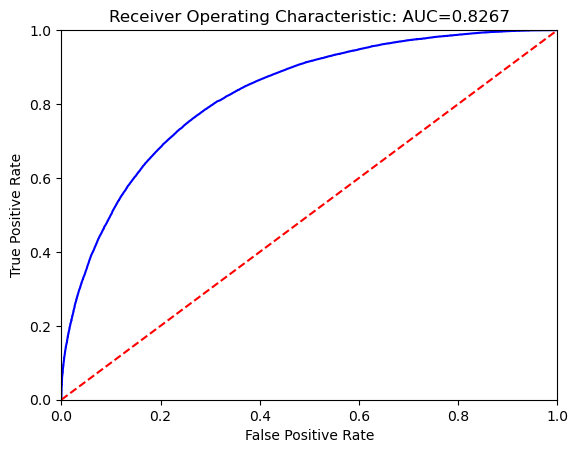

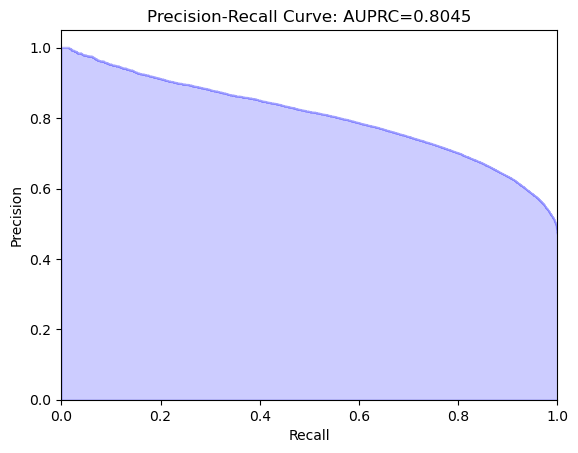

In [132]:
# run the tuned RF model 
print("RandomForest:") # 0.827

start = time.time()
rf_tuned.fit(X_train_b,y_train_b)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs_tuned = rf_tuned.predict_proba(X_test_b)
result = PlotROCCurve(probs_tuned[:,1],y_test_b, ci=confidence_interval, random_seed=random_seed)

results = ["RF_tuned_with_MinMaxScaling"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

In [137]:
# Feature importance for RF model
rf_feature_importance = pd.DataFrame(
        {
            'features': np.array(X_train_b.columns),    
            'importance' : rf_tuned.feature_importances_
            })

# Check top 20 features
rf_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20]

,features,importance
98,triage_acuity,0.178606
100,score_CCI,0.066726
105,n_medrecon,0.049531
99,triage_MAP,0.044287
101,score_CART,0.043941
102,score_REMS,0.040910
96,triage_sbp,0.040053
92,triage_temperature,0.038560
93,triage_heartrate,0.038291
95,triage_o2sat,0.033385


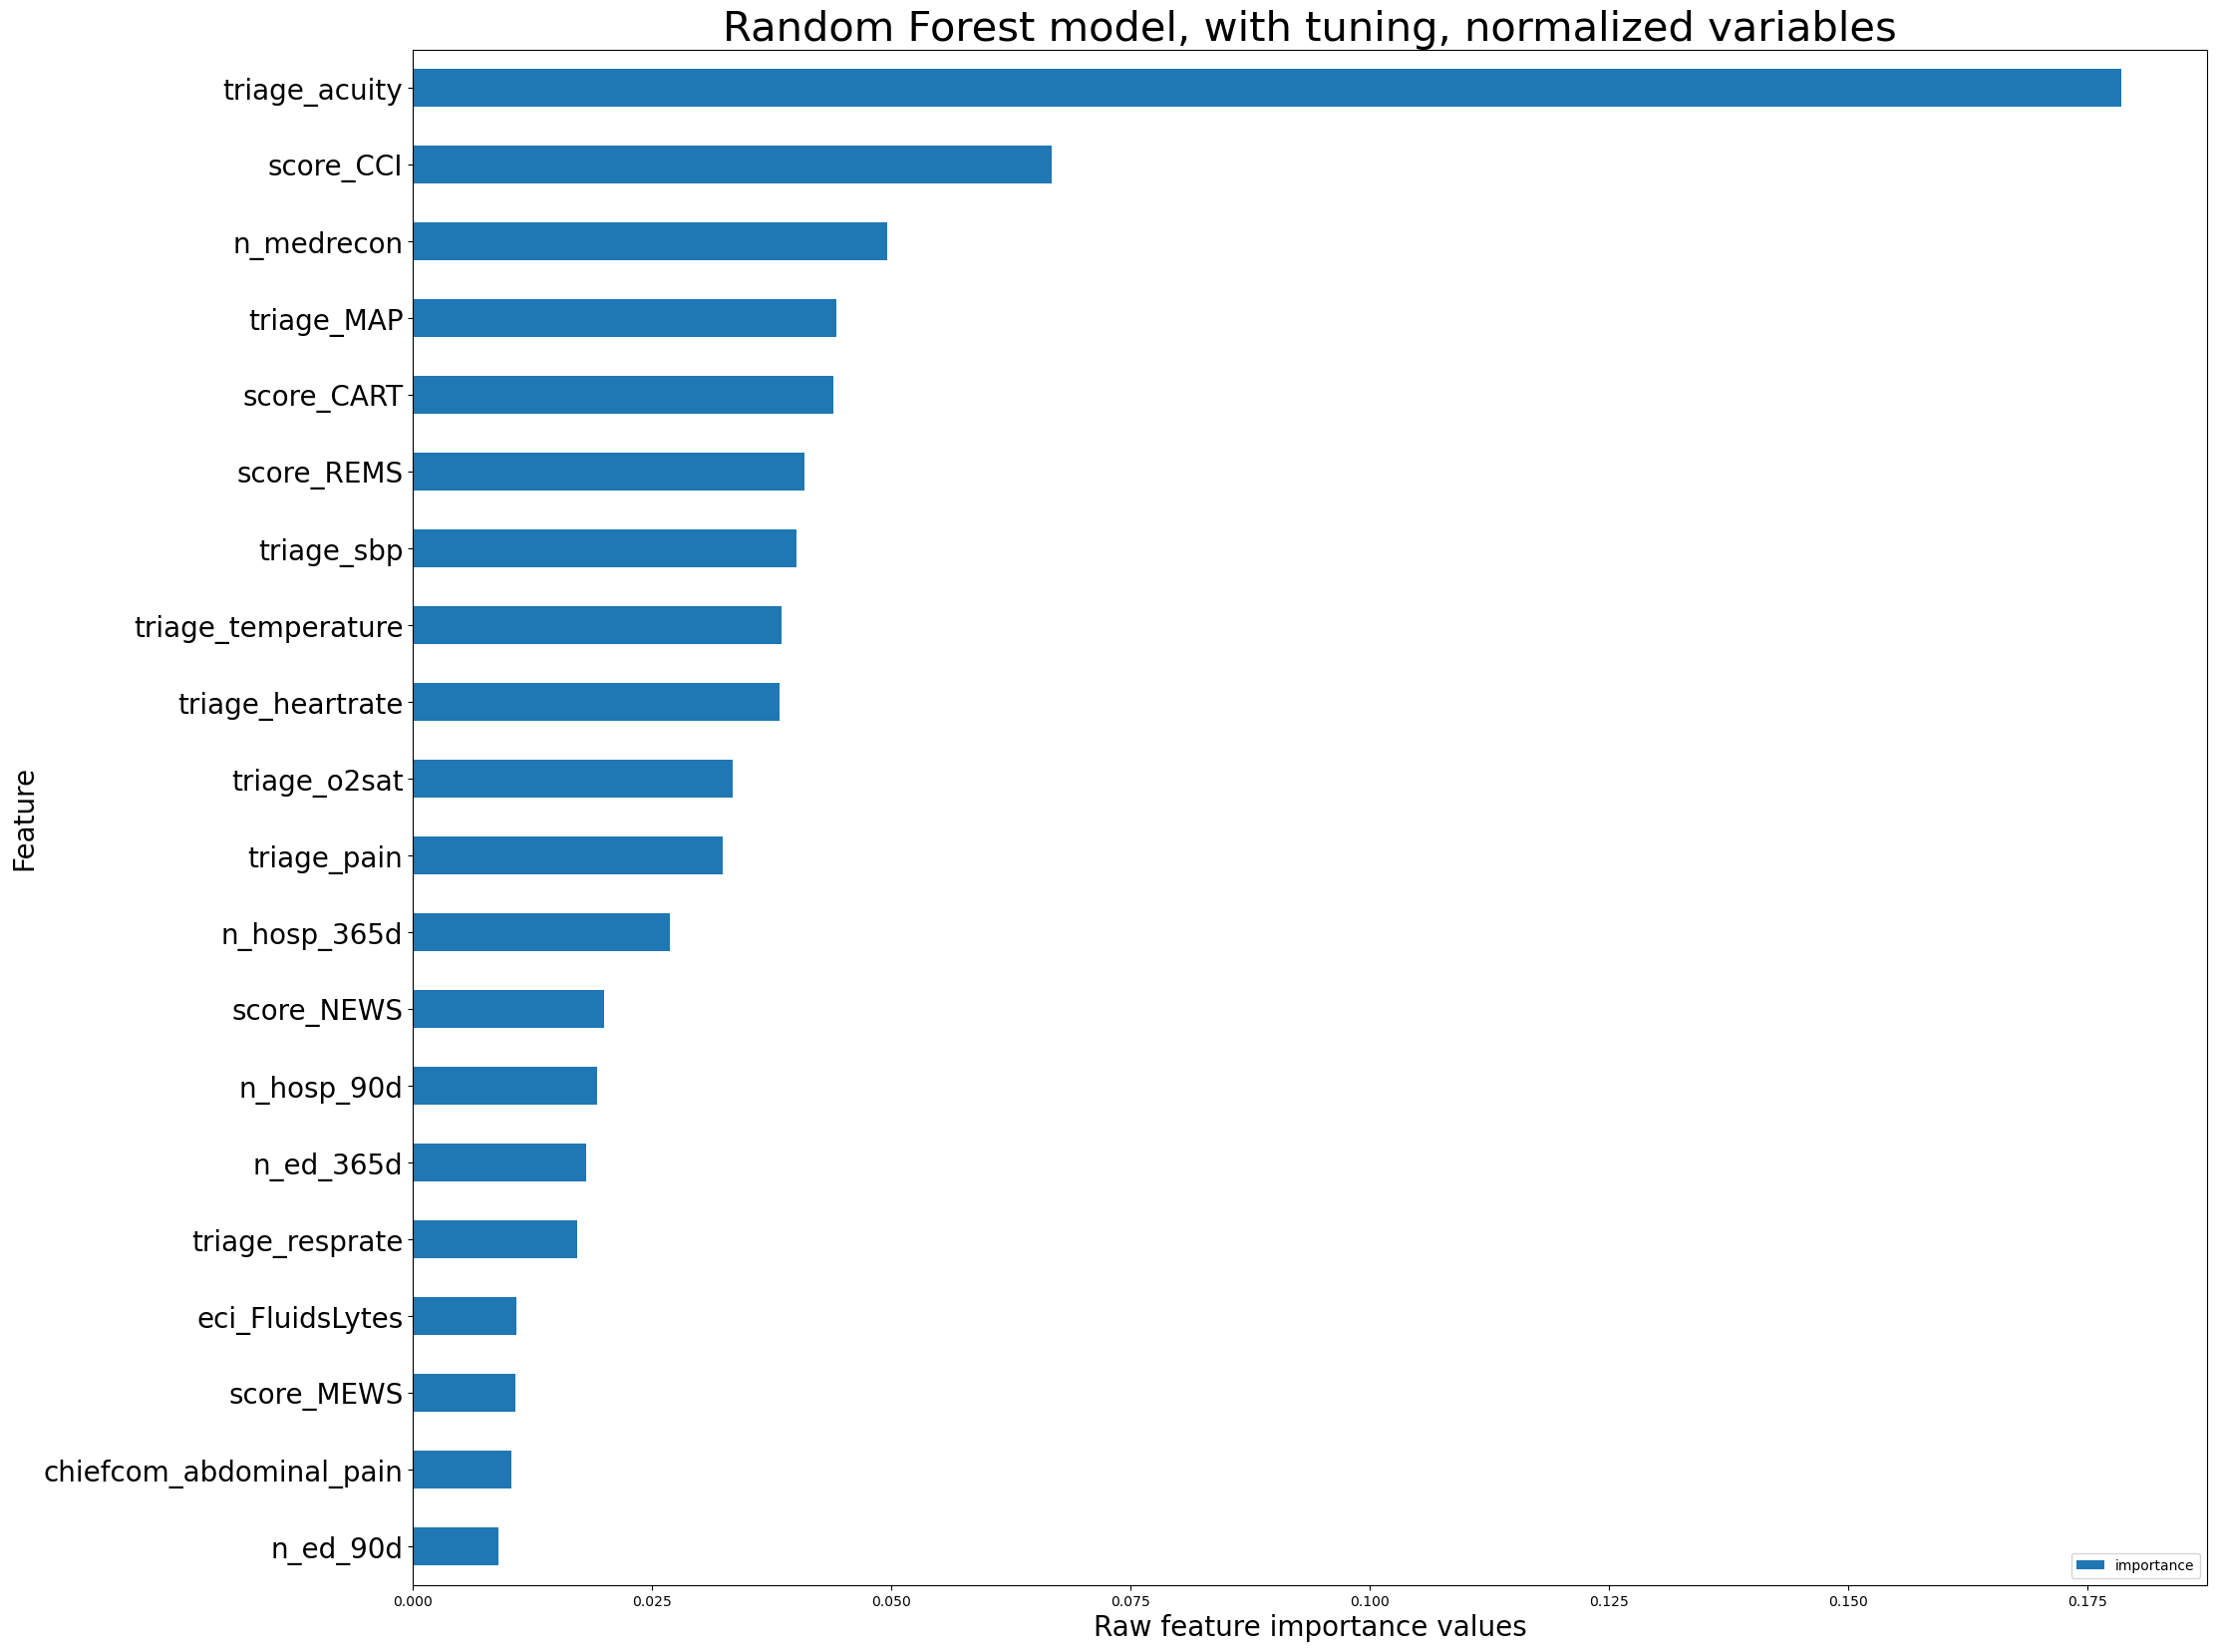

In [138]:
# Plot feature importance bar chart

sorted_feature_importance = rf_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20].set_index('features')

sorted_feature_importance.sort_values(by='importance',key=lambda x:abs(x)).plot.barh(figsize=(30, 20))
plt.title("Random Forest model, with tuning, normalized variables", fontsize=30)
plt.xlabel("Raw feature importance values", fontsize=20)
plt.ylabel('Feature',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

(vi) Performance Output for RF modelling

In [133]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_rf, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
#formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,RF_base,0.484,0.819 (0.817-0.821),0.79 (0.786-0.792),0.758 (0.74-0.762),0.728 (0.725-0.743),71.495
1,RF_base_variables_with_features_caling,0.488,0.82 (0.817-0.822),0.79 (0.786-0.793),0.76 (0.74-0.762),0.728 (0.725-0.748),71.647
2,RF_add_variables_with_MinMax,0.495,0.821 (0.819-0.823),0.791 (0.786-0.793),0.747 (0.743-0.758),0.743 (0.732-0.744),79.562
3,RF_add_variables_with_RobustScaler,0.495,0.821 (0.819-0.823),0.791 (0.786-0.793),0.746 (0.734-0.756),0.742 (0.732-0.753),81.160
4,RF_tuned_with_MinMaxScaling,0.493,0.827 (0.824-0.828),0.804 (0.801-0.806),0.753 (0.746-0.762),0.742 (0.732-0.749),273.703


## c. Gradient Boosting

In [64]:
# Containers for all results
result_list_gb = []

(i) Base Model as per sample codes

GradientBoosting:
Training time: 69.3162350654602 seconds
AUC: 0.8124817664234992
AUPRC: 0.7838569121033884
Sensitivity: 0.7527557592271489
Specificity: 0.7220955452978144
Score thresold: 0.477742931844386
2.5 97.5


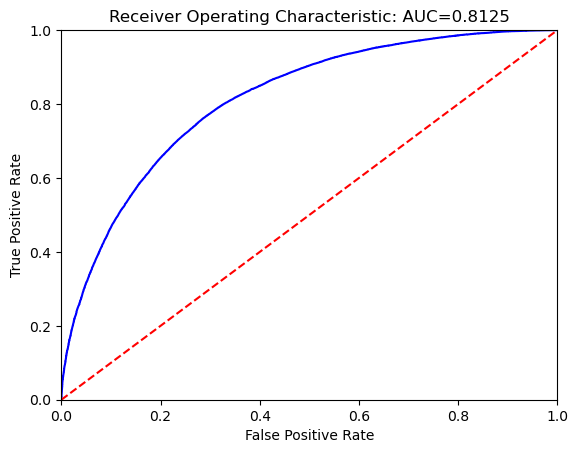

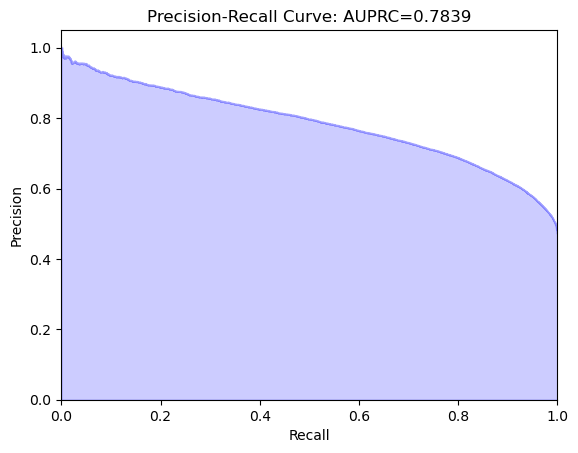

In [65]:
print("GradientBoosting:") #0.819, 0.8125, 0.8125

gb = GradientBoostingClassifier(random_state=1234)
start = time.time()
gb.fit(X_train_default,y_train_default)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test_default)
result = PlotROCCurve(probs[:,1],y_test_default, ci=confidence_interval, random_seed=random_seed)

results = ["GB_base"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

(ii) Base variables but applied one-hot encoding on "gender" and feature scale numeric variables

GradientBoosting:
Training time: 74.37638664245605 seconds
AUC: 0.8124817664234992
AUPRC: 0.7838569121033884
Sensitivity: 0.7527557592271489
Specificity: 0.7220955452978144
Score thresold: 0.477742931844386
2.5 97.5


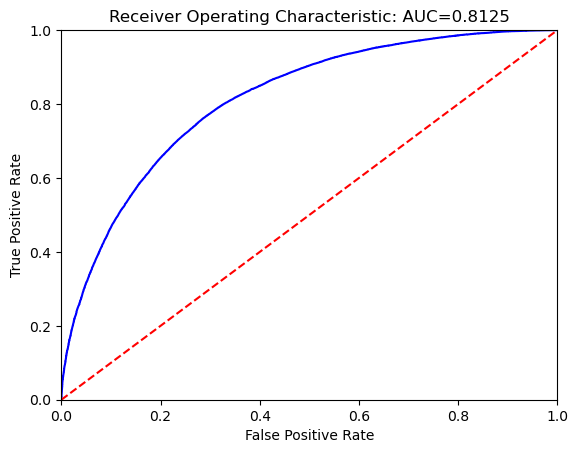

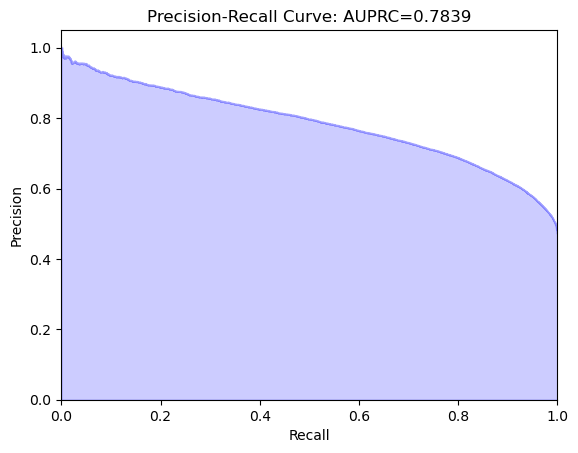

In [66]:
print("GradientBoosting:") #0.8187, 0.8125, 0.8125

gb = GradientBoostingClassifier(random_state=1234)
start = time.time()
gb.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB_base_variables_with_features_caling"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

(iii) Additional variables (with MinMaxScaling for Numerical Variable)

GradientBoosting:
Training time: 140.24168753623962 seconds
AUC: 0.8147566214203728
AUPRC: 0.7858798799844339
Sensitivity: 0.7452625712162497
Specificity: 0.7311328624659363
Score thresold: 0.48284187845244997
2.5 97.5


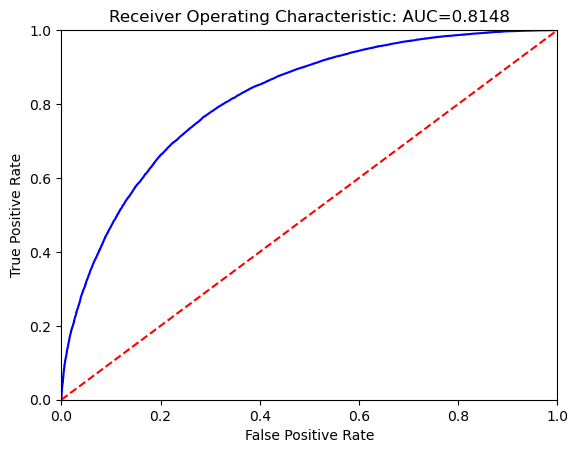

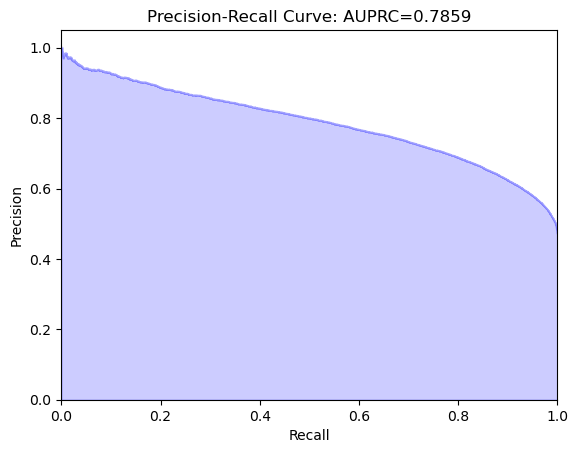

In [67]:
print("GradientBoosting:") #0.8204, 0.8147, 0.8148

gb_b = GradientBoostingClassifier(random_state=1234)
start = time.time()
gb_b.fit(X_train_b,y_train_b)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs_b = gb_b.predict_proba(X_test_b)
result = PlotROCCurve(probs_b[:,1],y_test_b, ci=confidence_interval, random_seed=random_seed)

results = ["GB_add_variables_with_MinMax"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

In [117]:
# Print hyperparameters used in the current model
print('Parameters currently in use:\n')
pprint(gb_b.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 1234,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


(iv) Additional variables with RobustScaling for Numerical Variables

GradientBoosting:
Training time: 115.78343558311462 seconds
AUC: 0.8147566214203728
AUPRC: 0.7858798799844339
Sensitivity: 0.7452625712162497
Specificity: 0.7311328624659363
Score thresold: 0.48284187845244997
2.5 97.5


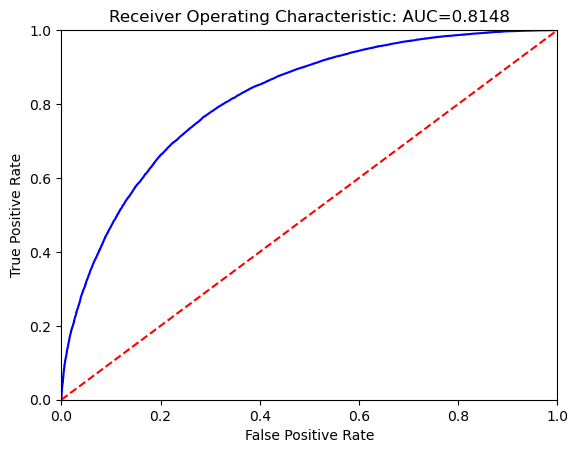

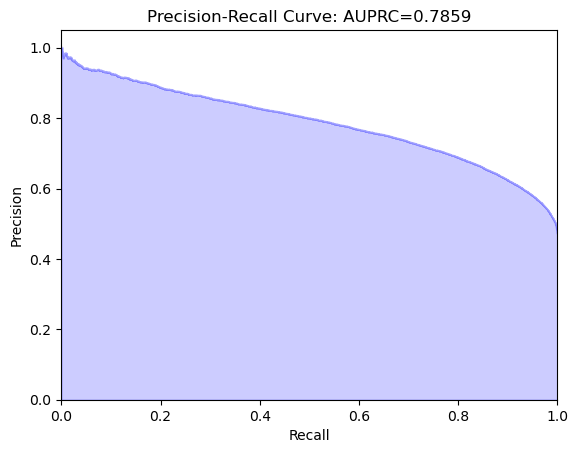

In [68]:
print("GradientBoosting:") # 0.8204, 0.8147, 0.8148

gb_b_ii = GradientBoostingClassifier(random_state=1234)
start = time.time()
gb_b_ii.fit(X_train_b_ii,y_train_b)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs_b_ii = gb_b_ii.predict_proba(X_test_b_ii)
result = PlotROCCurve(probs_b_ii[:,1],y_test_b, ci=confidence_interval, random_seed=random_seed)

results = ["GB_add_variables_with_RobustScaler"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

In [74]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_gb, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
#formatted_result_df.to_csv(os.path.join(path, 'age_bin_equal_GB.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,GB_base,0.478,0.812 (0.81-0.815),0.784 (0.779-0.788),0.753 (0.738-0.764),0.722 (0.714-0.735),69.316
1,GB_base_variables_with_features_caling,0.478,0.812 (0.81-0.815),0.784 (0.779-0.788),0.753 (0.738-0.764),0.722 (0.714-0.735),74.376
2,GB_add_variables_with_MinMax,0.483,0.815 (0.812-0.818),0.786 (0.782-0.79),0.745 (0.739-0.768),0.731 (0.711-0.739),140.242
3,GB_add_variables_with_RobustScaler,0.483,0.815 (0.812-0.818),0.786 (0.782-0.79),0.745 (0.739-0.768),0.731 (0.711-0.739),115.783


(v) Conduct Hyperparameter tuning

Hyper-parameters to tune:

- learning_rate: [1, 0.5, 0.25, 0.1, 0.05, 0.01]
- n_estimators: [1, 2, 4, 8, 16, 32, 64, 100, 200]
- max_depth: np.linspace(1, 10, 10, endpoint=True)
- min_samples_split: [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
- min_samples_leaf = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
- max_features = [5,10,15,20,25,50,100,None]

<br>References: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

<br>Other References:
- https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
- https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/

In [95]:
# Assign range of values for the hyperparameters

# learning rate shrinks the contribution of each tree by learning_rate. 
# There is a trade-off between learning_rate and n_estimators.
learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

# n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. 
# However, adding a lot of trees can slow down the training process considerably
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

#max_depth indicates how deep the built tree can be. 
#The deeper the tree, the more splits it has and it captures more information about how the data.
max_depth =  np.linspace(1, 10, 10, endpoint=True)


# min_samples_split represents the minimum number of samples required to split an internal node
# Here we will vary the parameter from 10% to 100% of the samples
min_samples_split = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

#min_samples_leaf is The minimum number of samples required to be at a leaf node. 
#This similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs.
min_samples_leaf = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# max_features represents the number of features to consider when looking for the best split.
max_features = [5,10,15,20,25,50,100,None]


#### Tuning: learnig_rate and n_estimators

In [38]:
# Create the parameters for tuning
param_grid = {'learning_rate': learning_rate,
              'n_estimators': n_estimators}

clf = GradientBoostingClassifier(random_state=1234)
rand_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, scoring='roc_auc', n_iter=50, n_jobs=-1, refit=True,cv=5, verbose =3)

start = time.time()

# Fit the grid search model
rand_search.fit(X_train_b,y_train_b)

runtime = time.time()-start

print('Random Grid Search Tuning time:', runtime, 'seconds')

rand_search_results = pd.DataFrame(rand_search.cv_results_)

print('Best Score: ', rand_search.best_score_) 
print('Best Params: ', rand_search.best_params_)

# Rename mean_test_score to mean_roc_auc
rand_search_results["mean_roc_auc"] = rand_search_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rand_search_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True)

Random Grid Search Tuning time: 3525.2916083335876 seconds
Best Score:  0.8287637149167721
Best Params:  {'n_estimators': 200, 'learning_rate': 0.25}


,param_learning_rate,param_n_estimators,mean_roc_auc,rank_test_score
0,0.25,200,0.828764,1
1,0.5,100,0.827412,2
2,0.25,100,0.826741,3
3,0.5,64,0.826483,4
4,0.1,200,0.826199,5
5,1,100,0.824853,6
6,0.25,64,0.824582,7
7,1,200,0.824452,8
8,1,64,0.824317,9
9,0.5,32,0.823086,10


In [ ]:
# Replace tuned parameter(s) with best value
learning_rate = [] 
learning_rate.append(rand_search.best_params_['learning_rate'])

n_estimators = [] 
n_estimators.append(rand_search.best_params_['n_estimators'])

learning_rate, n_estimators

In [96]:
learning_rate = [0.25]
n_estimators = [200] 

#### Tuning: Max_Depth

In [82]:
# Create the parameters for tuning
param_grid = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth}

print(param_grid)

clf = GradientBoostingClassifier(random_state=1234)
# Instantiate the grid search model
gb_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
gb_grid.fit(X_train_b,y_train_b)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

gb_grid_results = pd.DataFrame(gb_grid.cv_results_)

print('Best Score: ', gb_grid.best_score_) 
print('Best Params: ', gb_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
gb_grid_results["mean_roc_auc"] = gb_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
gb_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True)

{'learning_rate': [0.25], 'n_estimators': [200], 'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Grid Search Tuning time: 5542.797381162643 seconds
Best Score:  0.829692458945724
Best Params:  {'learning_rate': 0.25, 'max_depth': 4.0, 'n_estimators': 200}


,param_learning_rate,param_n_estimators,param_max_depth,mean_roc_auc,rank_test_score
0,0.25,200,4.0,0.829692,1
1,0.25,200,5.0,0.829421,2
2,0.25,200,3.0,0.828764,3
3,0.25,200,6.0,0.828453,4
4,0.25,200,7.0,0.825977,5
5,0.25,200,2.0,0.825825,6
6,0.25,200,8.0,0.822576,7
7,0.25,200,9.0,0.818463,8
8,0.25,200,1.0,0.816981,9
9,0.25,200,10.0,0.813199,10


In [84]:
# Replace tuned parameter(s) with best value
max_depth = [] 
max_depth.append(gb_grid.best_params_['max_depth'])

max_depth

[4.0]

In [97]:
max_depth = [4.0]

#### Tuning: min_samples_split and min_samples_leaf using Random Grid Search

In [98]:
# Create the parameters for tuning
param_grid = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

print(param_grid)

clf = GradientBoostingClassifier(random_state=1234)
rand_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, scoring='roc_auc', n_iter=50, n_jobs=-1, refit=True,cv=5, verbose =3)

start = time.time()

# Fit the grid search model
rand_search.fit(X_train_b,y_train_b)

runtime = time.time()-start

print('Random Grid Search Tuning time:', runtime, 'seconds')

rand_search_results = pd.DataFrame(rand_search.cv_results_)

print('Best Score: ', rand_search.best_score_) 
print('Best Params: ', rand_search.best_params_)

# Rename mean_test_score to mean_roc_auc
rand_search_results["mean_roc_auc"] = rand_search_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rand_search_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True)

{'learning_rate': [0.25], 'n_estimators': [200], 'max_depth': [4.0], 'min_samples_split': [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], 'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Grid Search Tuning time: 37741.96712088585 seconds
Best Score:  0.8301499026182826
Best Params:  {'n_estimators': 200, 'min_samples_split': 1024, 'min_samples_leaf': 256, 'max_depth': 4.0, 'learning_rate': 0.25}


,param_learning_rate,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_roc_auc,rank_test_score
0,0.25,200,4.0,1024,256,0.830150,1
1,0.25,200,4.0,512,64,0.830150,2
2,0.25,200,4.0,32,512,0.830145,3
3,0.25,200,4.0,128,512,0.830145,3
4,0.25,200,4.0,256,512,0.830145,3
5,0.25,200,4.0,512,512,0.830145,3
6,0.25,200,4.0,8,512,0.830145,3
7,0.25,200,4.0,1024,32,0.830065,8
8,0.25,200,4.0,64,32,0.830048,9
9,0.25,200,4.0,16,32,0.830048,9


In [99]:
# Replace tuned parameter(s) with best value
min_samples_split = [] 
min_samples_split.append(rand_search.best_params_['min_samples_split'])

min_samples_leaf = [] 
min_samples_leaf.append(rand_search.best_params_['min_samples_leaf'])

min_samples_split, min_samples_leaf

([1024], [256])

#### Tuning: max_features

In [107]:
# Create the parameters for tuning
param_grid = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features}

print(param_grid)

clf = GradientBoostingClassifier(random_state=1234)
# Instantiate the grid search model
gb_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
gb_grid.fit(X_train_b,y_train_b)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

gb_grid_results = pd.DataFrame(gb_grid.cv_results_)

print('Best Score: ', gb_grid.best_score_) 
print('Best Params: ', gb_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
gb_grid_results["mean_roc_auc"] = gb_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
gb_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True)

{'learning_rate': [0.25], 'n_estimators': [200], 'max_depth': [4.0], 'min_samples_split': [1024], 'min_samples_leaf': [256], 'max_features': [5, 10, 15, 20, 25, 50, 100, None]}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid Search Tuning time: 1598.4169614315033 seconds
Best Score:  0.8302140762826158
Best Params:  {'learning_rate': 0.25, 'max_depth': 4.0, 'max_features': 100, 'min_samples_leaf': 256, 'min_samples_split': 1024, 'n_estimators': 200}


,param_learning_rate,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_roc_auc,rank_test_score
0,0.25,200,4.0,1024,256,100,0.830214,1
1,0.25,200,4.0,1024,256,None,0.830150,2
2,0.25,200,4.0,1024,256,50,0.830000,3
3,0.25,200,4.0,1024,256,25,0.829378,4
4,0.25,200,4.0,1024,256,20,0.829179,5
5,0.25,200,4.0,1024,256,15,0.828838,6
6,0.25,200,4.0,1024,256,10,0.828060,7
7,0.25,200,4.0,1024,256,5,0.826126,8


In [108]:
# Replace tuned parameter(s) with best value
max_features = [] 
max_features.append(gb_grid.best_params_['max_features'])

max_features

[100]

In [110]:
# Print hyperparameters used in the tuned model
print('Parameters currently in use:\n')
pprint(gb_grid.best_params_)

Parameters currently in use:

{'learning_rate': 0.25,
 'max_depth': 4.0,
 'max_features': 100,
 'min_samples_leaf': 256,
 'min_samples_split': 1024,
 'n_estimators': 200}


In [111]:
# assign the best estimator to to log_reg_tuned
gb_tuned = gb_grid.best_estimator_
gb_tuned

GradientBoostingClassifier(learning_rate=0.25, max_depth=4.0, max_features=100,
                           min_samples_leaf=256, min_samples_split=1024,
                           n_estimators=200, random_state=1234)

In [112]:
# Save the tuned model
pickle.dump(gb_tuned, open('gb_tuned.pkl','wb'))

In [ ]:
# load the tuned model
# gb_tuned = pickle.load(open('gb_tuned.pkl', 'rb'))

GradientBoosting:
Training time: 252.0147397518158 seconds
AUC: 0.8291252883747522
AUPRC: 0.8079558628342809
Sensitivity: 0.7530425598310089
Specificity: 0.7454084046625662
Score thresold: 0.4847873602401132
2.5 97.5


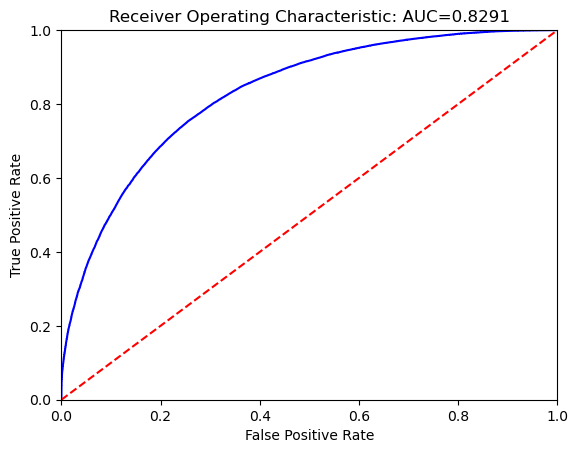

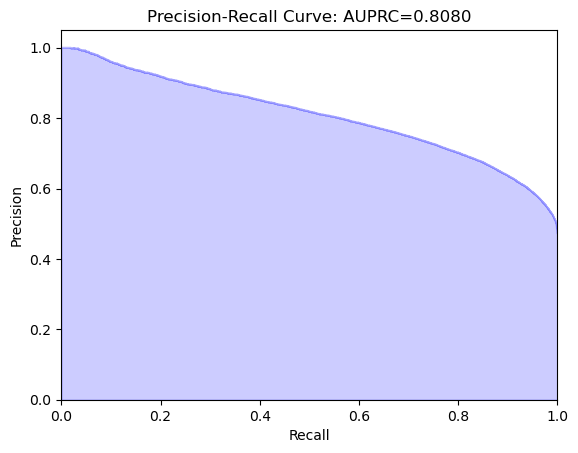

In [122]:
# run the tuned RF model 
print("GradientBoosting:") #0.8291

start = time.time()
gb_tuned.fit(X_train_b,y_train_b)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs_tuned = gb_tuned.predict_proba(X_test_b)
result = PlotROCCurve(probs_tuned[:,1],y_test_b, ci=confidence_interval, random_seed=random_seed)

results = ["GB_tuned_with_MinMaxScaling"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

In [124]:
# Feature importance for GB model
gb_feature_importance = pd.DataFrame(
        {
            'features': np.array(X_train_b.columns),    
            'importance' : gb_tuned.feature_importances_
            })

# Check top 20 features
gb_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20]

,features,importance
98,triage_acuity,0.454391
100,score_CCI,0.219325
105,n_medrecon,0.035915
88,n_hosp_365d,0.032258
95,triage_o2sat,0.028544
87,n_hosp_90d,0.021292
101,score_CART,0.020015
97,triage_pain,0.018431
85,n_ed_365d,0.018238
103,score_NEWS,0.015206


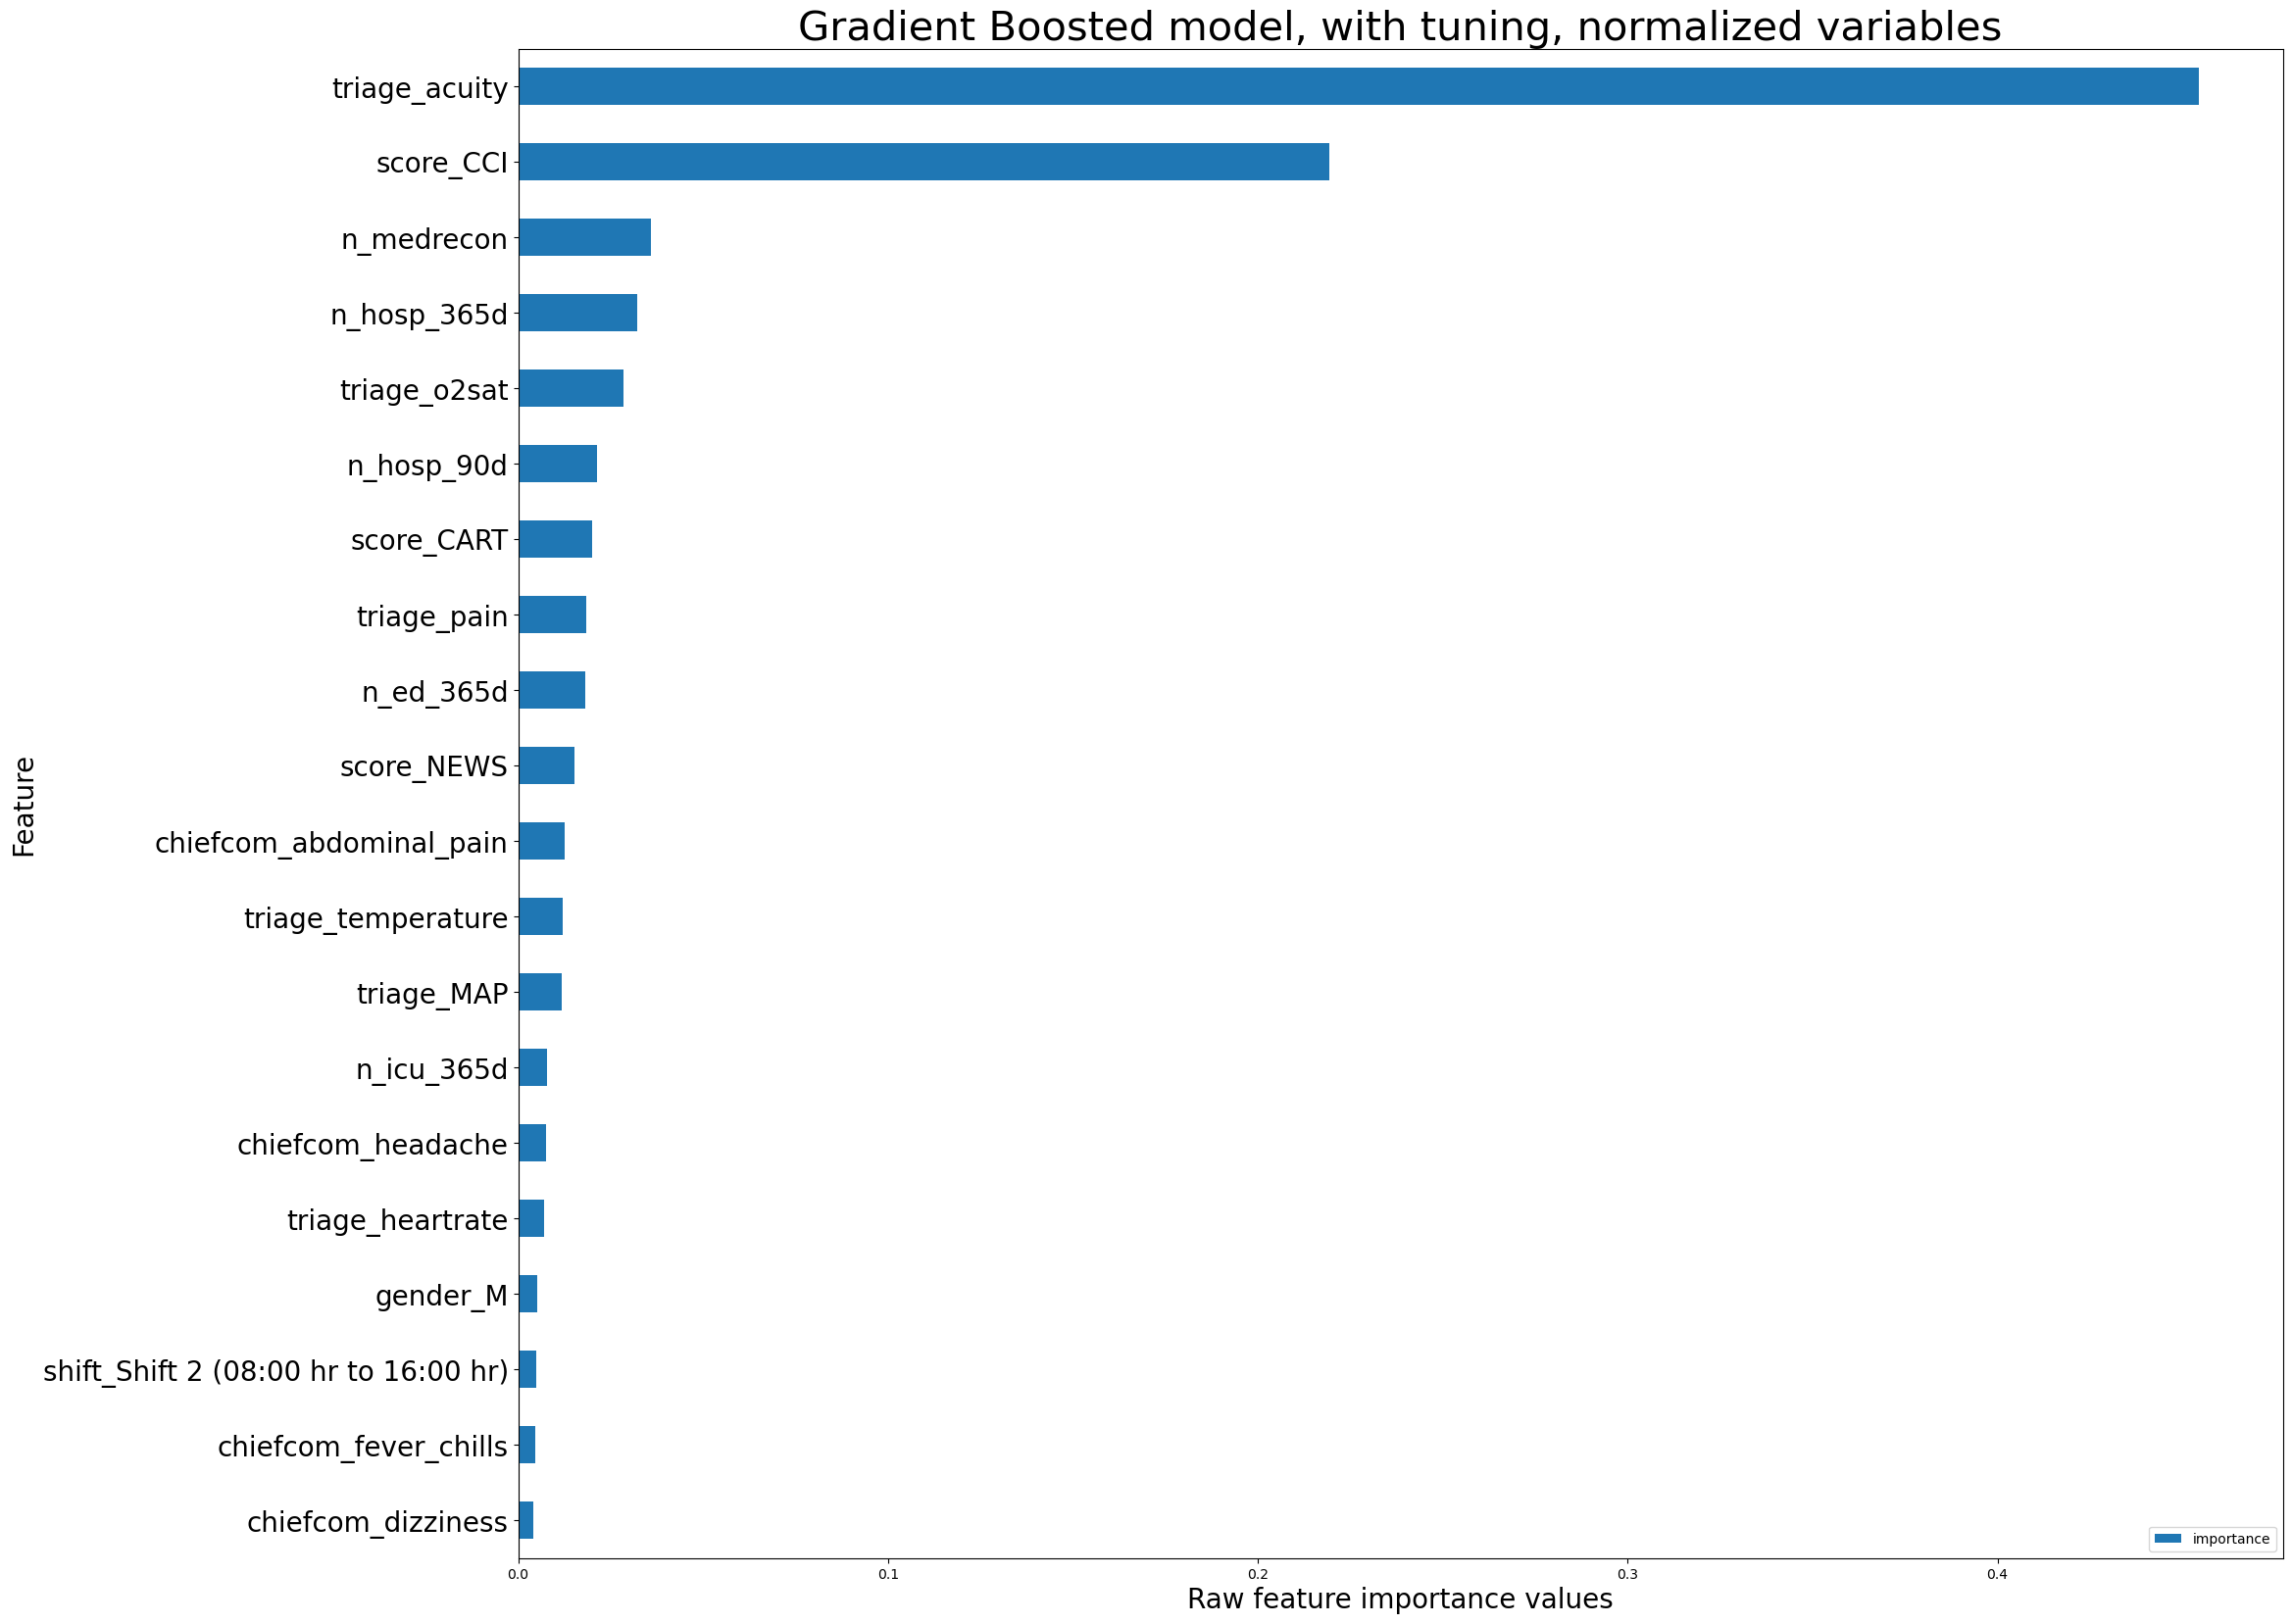

In [125]:
# Plot feature importance bar chart

sorted_feature_importance = gb_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20].set_index('features')

sorted_feature_importance.sort_values(by='importance',key=lambda x:abs(x)).plot.barh(figsize=(30, 20))
plt.title("Gradient Boosted model, with tuning, normalized variables", fontsize=30)
plt.xlabel("Raw feature importance values", fontsize=20)
plt.ylabel('Feature',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)


(vi) Performance Output for GB modelling

In [126]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_gb, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
#formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,GB_base,0.483,0.819 (0.816-0.821),0.796 (0.792-0.798),0.747 (0.742-0.761),0.732 (0.717-0.738),67.668
1,GB_base_variables_with_features_caling,0.483,0.819 (0.816-0.821),0.796 (0.792-0.798),0.747 (0.742-0.761),0.732 (0.717-0.738),67.204
2,GB_add_variables_with_MinMax,0.489,0.82 (0.818-0.822),0.797 (0.793-0.799),0.749 (0.74-0.754),0.735 (0.732-0.741),102.241
3,GB_add_variables_with_RobustScaler,0.489,0.82 (0.818-0.822),0.797 (0.793-0.799),0.749 (0.74-0.754),0.735 (0.732-0.741),103.184
4,GB_tuned_with_MinMaxScaling,0.485,0.829 (0.827-0.831),0.808 (0.804-0.81),0.753 (0.747-0.757),0.745 (0.738-0.752),252.015


## d. MLP

In [53]:
# Containers for all results
result_list_mlp = []

(i) Base Model as per sample codes

In [54]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [55]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train_default.astype(np.float32), y_train_default, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
#mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1366/1366 [==============================] - 7s 3ms/step - loss: 0.6039 - accuracy: 0.7017 - auc: 0.7655 - auprc: 0.7206 - true_positives: 84255.0000 - true_negatives: 107338.0000 - precision: 0.6941 - recall: 0.6554
Epoch 2/20
1366/1366 [==============================] - 4s 3ms/step - loss: 0.5500 - accuracy: 0.7197 - auc: 0.7934 - auprc: 0.7593 - true_positives: 88191.0000 - true_negatives: 108302.0000 - precision: 0.7092 - recall: 0.6860
Epoch 3/20
1366/1366 [==============================] - 5s 3ms/step - loss: 0.5466 - accuracy: 0.7216 - auc: 0.7961 - auprc: 0.7627 - true_positives: 89233.0000 - true_negatives: 107786.0000 - precision: 0.7087 - recall: 0.6941
Epoch 4/20
1366/1366 [==============================] - 5s 3ms/step - loss: 0.5425 - accuracy: 0.7248 - auc: 0.7993 - auprc: 0.7665 - true_positives: 89946.0000 - true_negatives: 107959.0000 - precision: 0.7113 - recall: 0.6996
Epoch 5/20
1366/1366 [==============================] - 4s 3ms/step - loss: 0.5397 - acc

MLP:
2134/2134 [==============================] - 3s 1ms/step
AUC: 0.8167095582631142
AUPRC: 0.7865629498847271
Sensitivity: 0.7571525885558583
Specificity: 0.7260719648517879
Score thresold: 0.50159514
2.5 97.5


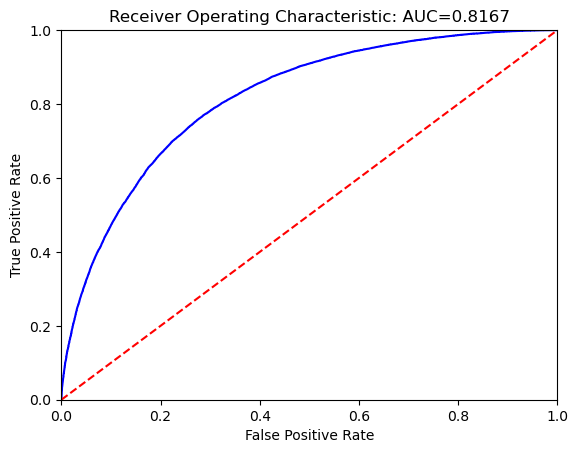

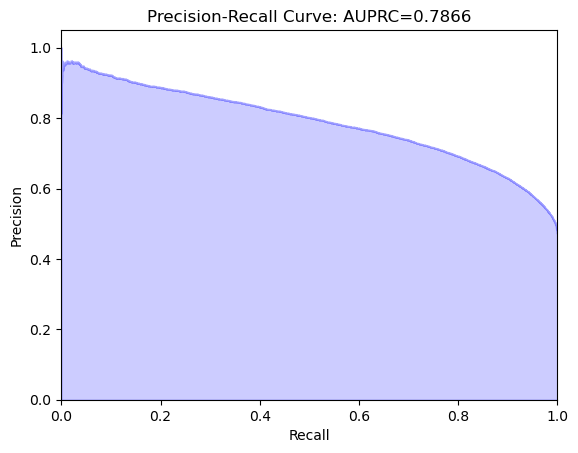

In [56]:
print("MLP:") #0.8224, 0.8166, 0.8167
#mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test_default.astype(np.float32))
result = PlotROCCurve(probs,y_test_default, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_base"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

(ii) Base variables but applied one-hot encoding on "gender" and feature scale numeric variables

In [57]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
#mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1366/1366 [==============================] - 7s 4ms/step - loss: 0.5780 - accuracy: 0.6982 - auc: 0.7663 - auprc: 0.7252 - true_positives: 82939.0000 - true_negatives: 107702.0000 - precision: 0.6929 - recall: 0.6451
Epoch 2/20
1366/1366 [==============================] - 6s 5ms/step - loss: 0.5511 - accuracy: 0.7177 - auc: 0.7916 - auprc: 0.7521 - true_positives: 88249.0000 - true_negatives: 107699.0000 - precision: 0.7059 - recall: 0.6864
Epoch 3/20
1366/1366 [==============================] - 6s 4ms/step - loss: 0.5451 - accuracy: 0.7217 - auc: 0.7962 - auprc: 0.7581 - true_positives: 90482.0000 - true_negatives: 106560.0000 - precision: 0.7047 - recall: 0.7038
Epoch 4/20
1366/1366 [==============================] - 6s 4ms/step - loss: 0.5422 - accuracy: 0.7243 - auc: 0.7985 - auprc: 0.7613 - true_positives: 91618.0000 - true_negatives: 106150.0000 - precision: 0.7051 - recall: 0.7126
Epoch 5/20
1366/1366 [==============================] - 5s 3ms/step - loss: 0.5393 - acc

MLP:
2134/2134 [==============================] - 3s 1ms/step
AUC: 0.813797381348107
AUPRC: 0.7831167405683177
Sensitivity: 0.7463462967550161
Specificity: 0.7340804182192314
Score thresold: 0.44895428
2.5 97.5


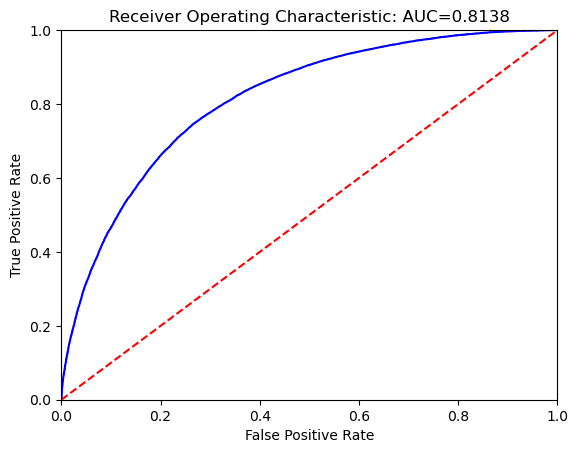

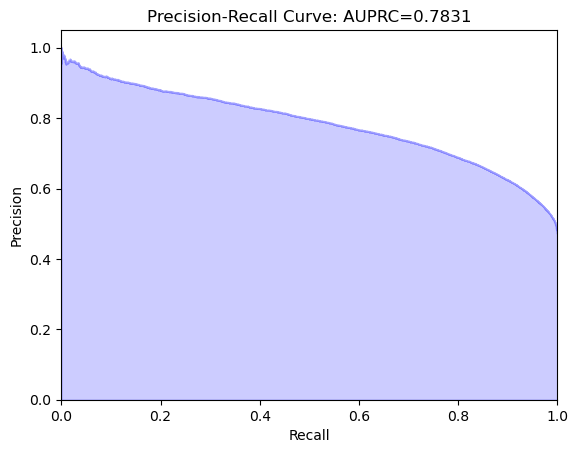

In [58]:
print("MLP:") #0.8214, 0.8143, 0.8138
#mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_base_variables_with_features_caling"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

(iii) Additional variables (with MinMaxScaling for Numerical Variable)

In [59]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train_b.astype(np.float32), y_train_b, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
#mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1366/1366 [==============================] - 7s 4ms/step - loss: 0.5447 - accuracy: 0.7214 - auc: 0.7962 - auprc: 0.7614 - true_positives: 90338.0000 - true_negatives: 106623.0000 - precision: 0.7047 - recall: 0.7027
Epoch 2/20
1366/1366 [==============================] - 6s 4ms/step - loss: 0.5283 - accuracy: 0.7336 - auc: 0.8105 - auprc: 0.7792 - true_positives: 93493.0000 - true_negatives: 106802.0000 - precision: 0.7128 - recall: 0.7272
Epoch 3/20
1366/1366 [==============================] - 6s 4ms/step - loss: 0.5235 - accuracy: 0.7360 - auc: 0.8145 - auprc: 0.7847 - true_positives: 93826.0000 - true_negatives: 107135.0000 - precision: 0.7153 - recall: 0.7298
Epoch 4/20
1366/1366 [==============================] - 6s 4ms/step - loss: 0.5198 - accuracy: 0.7393 - auc: 0.8176 - auprc: 0.7891 - true_positives: 94198.0000 - true_negatives: 107646.0000 - precision: 0.7189 - recall: 0.7327
Epoch 5/20
1366/1366 [==============================] - 5s 4ms/step - loss: 0.5172 - acc

MLP:
2134/2134 [==============================] - 2s 948us/step
AUC: 0.812702333117374
AUPRC: 0.7800456901875098
Sensitivity: 0.7387292543968293
Specificity: 0.7350814748901618
Score thresold: 0.47143915
2.5 97.5


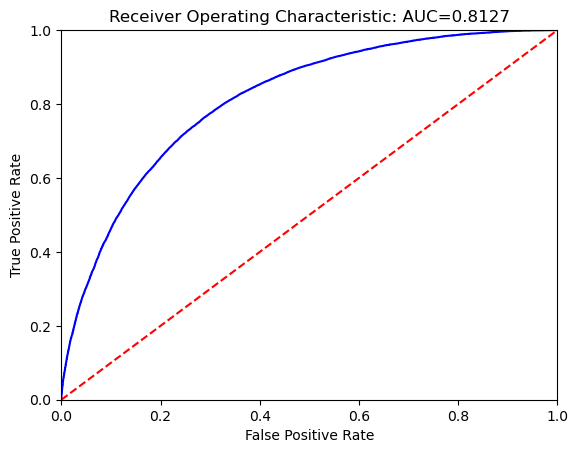

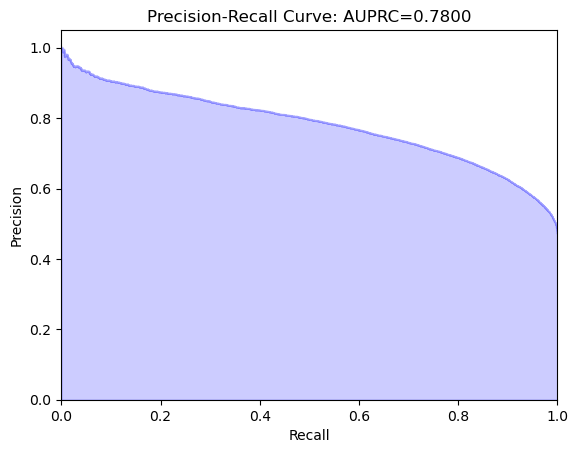

In [60]:
print("MLP:") #0.8198, 0.8130, 0.8127
#mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test_b.astype(np.float32))
result = PlotROCCurve(probs,y_test_b, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_add_variables_with_MinMax"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

(iv) Additional variables with RobustScaling for Numerical Variables

In [61]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train_b_ii.astype(np.float32), y_train_b, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
#mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1366/1366 [==============================] - 7s 4ms/step - loss: 0.5286 - accuracy: 0.7344 - auc: 0.8106 - auprc: 0.7795 - true_positives: 93477.0000 - true_negatives: 107028.0000 - precision: 0.7140 - recall: 0.7271
Epoch 2/20
1366/1366 [==============================] - 6s 4ms/step - loss: 0.5179 - accuracy: 0.7408 - auc: 0.8193 - auprc: 0.7904 - true_positives: 94395.0000 - true_negatives: 107860.0000 - precision: 0.7205 - recall: 0.7342
Epoch 3/20
1366/1366 [==============================] - 5s 4ms/step - loss: 0.5142 - accuracy: 0.7439 - auc: 0.8224 - auprc: 0.7946 - true_positives: 95016.0000 - true_negatives: 108099.0000 - precision: 0.7232 - recall: 0.7391
Epoch 4/20
1366/1366 [==============================] - 6s 4ms/step - loss: 0.5117 - accuracy: 0.7454 - auc: 0.8244 - auprc: 0.7974 - true_positives: 95067.0000 - true_negatives: 108449.0000 - precision: 0.7252 - recall: 0.7395
Epoch 5/20
1366/1366 [==============================] - 7s 5ms/step - loss: 0.5093 - acc

MLP:
2134/2134 [==============================] - 3s 1ms/step
AUC: 0.8103190483095599
AUPRC: 0.7798248598502999
Sensitivity: 0.737026257121625
Specificity: 0.733885768310995
Score thresold: 0.46744755
2.5 97.5


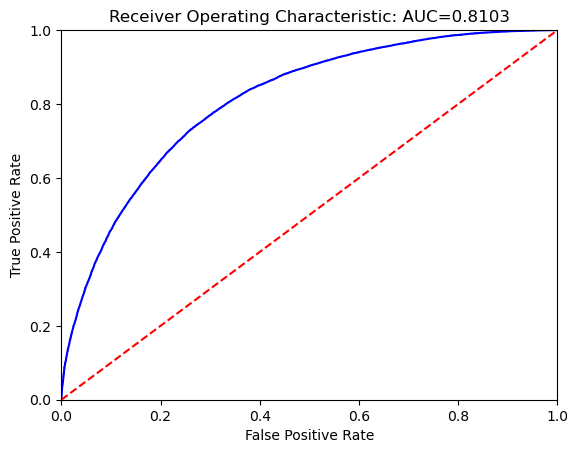

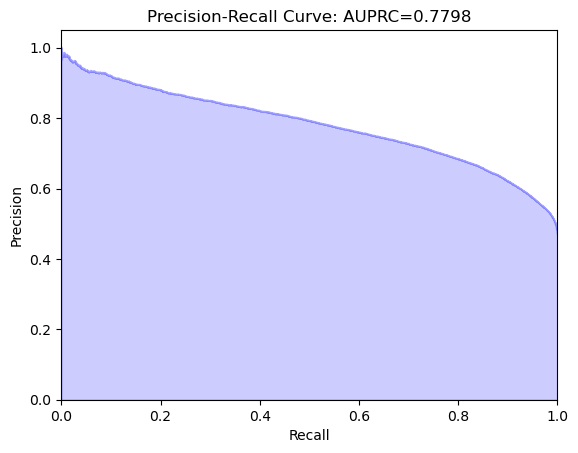

In [62]:
print("MLP:") #0.8206, 0.8100, 0.8103
#mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test_b_ii.astype(np.float32))
result = PlotROCCurve(probs,y_test_b, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_add_variables_with_RobustScaler"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

In [76]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_mlp, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
#formatted_result_df.to_csv(os.path.join(path, 'age_bin_equal_MLP.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,MLP_base,0.502,0.817 (0.814-0.819),0.787 (0.782-0.79),0.757 (0.738-0.763),0.726 (0.722-0.744),97.009
1,MLP_base_variables_with_features_caling,0.449,0.814 (0.811-0.816),0.783 (0.779-0.786),0.746 (0.743-0.756),0.734 (0.727-0.74),106.975
2,MLP_add_variables_with_MinMax,0.471,0.813 (0.81-0.816),0.78 (0.776-0.783),0.739 (0.732-0.768),0.735 (0.713-0.744),105.899
3,MLP_add_variables_with_RobustScaler,0.467,0.81 (0.808-0.813),0.78 (0.776-0.783),0.737 (0.73-0.746),0.734 (0.724-0.74),113.822


(v) Conduct Hyperparameter tuning

In [163]:
# Increase the no. of dense layers in model from 3 to 5 by amending the MLP method
class MLP_plus(tf.keras.Model):
    def __init__(self):
        super(MLP_plus, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        # Added dense layer #3 and #4
        self.dense_3 = Dense(32, activation='relu')
        self.dense_4 = Dense(16, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.dense_4(x)
        return self.classifier(x)

In [164]:
# Compile and train the model
mlp = MLP_plus()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train_b.astype(np.float32), y_train_b, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

Epoch 1/20
1764/1764 [==============================] - 4s 2ms/step - loss: 0.5313 - accuracy: 0.7322 - auc: 0.8080 - auprc: 0.7808 - true_positives: 120876.0000 - true_negatives: 137330.0000 - precision: 0.7145 - recall: 0.7238
Epoch 2/20
1764/1764 [==============================] - 3s 2ms/step - loss: 0.5170 - accuracy: 0.7410 - auc: 0.8198 - auprc: 0.7957 - true_positives: 123021.0000 - true_negatives: 138284.0000 - precision: 0.7221 - recall: 0.7367
Epoch 3/20
1764/1764 [==============================] - 3s 2ms/step - loss: 0.5126 - accuracy: 0.7437 - auc: 0.8232 - auprc: 0.8006 - true_positives: 123473.0000 - true_negatives: 138776.0000 - precision: 0.7249 - recall: 0.7394
Epoch 4/20
1764/1764 [==============================] - 3s 2ms/step - loss: 0.5096 - accuracy: 0.7458 - auc: 0.8255 - auprc: 0.8039 - true_positives: 123613.0000 - true_negatives: 139387.0000 - precision: 0.7277 - recall: 0.7402
Epoch 5/20
1764/1764 [==============================] - 3s 2ms/step - loss: 0.5075 -

MLP:
2755/2755 [==============================] - 2s 602us/step
AUC: 0.8188169416411037
AUPRC: 0.7922681054881408
Sensitivity: 0.7398641350008401
Specificity: 0.7436663942535162
Score thresold: 0.5318492
2.5 97.5


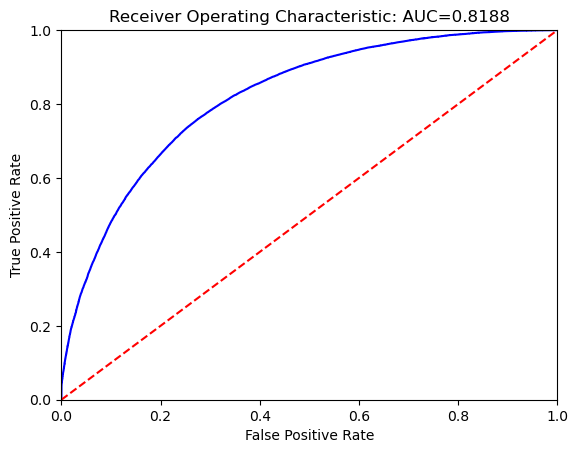

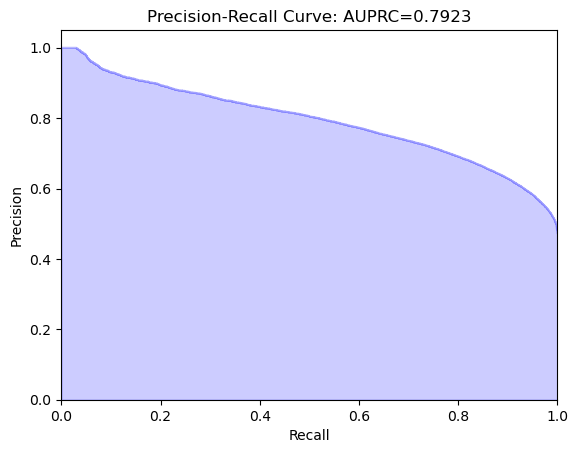

In [165]:
print("MLP:") #0.8188
#mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test_b.astype(np.float32))
result = PlotROCCurve(probs,y_test_b, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_add_variables_with_MinMax"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

#### Tune: Number of Layers and Neurons

In [179]:
#Convert pandas DataFrames to numpy arrays:
X_train_array = X_train_b.values.astype(np.float32)
y_train_array = y_train_b.values.astype(np.float32)

In [187]:
# Define MLP model creation function:
def create_mlp(num_layers, num_neurons):
    model = tf.keras.Sequential()
    model.add(Dense(num_neurons, activation='relu', input_dim=X_train_array.shape[1]))
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=0.001), 
                  metrics=['accuracy', 'AUC', 
                           tf.keras.metrics.AUC(name='auprc', curve='PR'),
                           'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
    
    return model

# Create the KerasClassifier wrapper:
model = KerasClassifier(build_fn=create_mlp, verbose=0)

# Define the parameter grid for grid search:
param_grid = {
    'num_layers': [3, 4, 5, 6, 7],  # Experiment with different numbers of layers
    'num_neurons': range(16, 257, 16)  # Experiment with different numbers of neurons
}

# Perform grid search using GridSearchCV:
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', refit=True, cv=5, n_jobs=-1, verbose=3)
grid_result = grid.fit(X_train_array, y_train_array, batch_size=200, epochs=20)

# Print the best parameters and results:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


C:\Users\kkb74\AppData\Local\Temp\ipykernel_9688\1075433923.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_mlp, verbose=0)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best: 0.824737 using {'num_layers': 3, 'num_neurons': 16}


In [188]:
grid_results = pd.DataFrame(grid_result.cv_results_)

print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_)

# Rename mean_test_score to mean_roc_auc
grid_results["mean_roc_auc"] = grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()


Best Score:  0.8247368251098139
Best Params:  {'num_layers': 3, 'num_neurons': 16}


,param_num_layers,param_num_neurons,mean_roc_auc,rank_test_score
0,3,16,0.824737,1
1,6,16,0.824731,2
2,4,16,0.824572,3
3,7,16,0.824521,4
4,5,16,0.824392,5


#### Tune: Dropout Rates, Learning Rate

In [191]:
# Define MLP model creation function with dropout and learning rates
def create_mlp_with_dropout(num_layers, num_neurons, dropout_rate, learning_rate):
    model = tf.keras.Sequential()
    model.add(Dense(num_neurons, activation='relu', input_dim=X_train_array.shape[1]))
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='relu'))
        model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy', 'AUC', 
                           tf.keras.metrics.AUC(name='auprc', curve='PR'),
                           'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
    
    return model

# Create the KerasClassifier wrapper
model_with_dropout = KerasClassifier(build_fn=create_mlp_with_dropout, verbose=0)

# Define the extended parameter grid for grid search
param_grid_with_dropout = {
    'num_layers': [3],  # From previous step
    'num_neurons': [16],  # From previous step
    'dropout_rate': [0.0, 0.2, 0.4, 0.6],  # Experiment with different dropout rates
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
}

# Perform grid search using GridSearchCV
grid_with_dropout = GridSearchCV(estimator=model_with_dropout, param_grid=param_grid_with_dropout, scoring='roc_auc', refit=True, cv=5, n_jobs=-1, verbose=3)

start = time.time()
grid_result_with_dropout = grid_with_dropout.fit(X_train_array, y_train_array, batch_size=200, epochs=20)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

# Print the best parameters and results
print("Best: %f using %s" % (grid_result_with_dropout.best_score_, grid_result_with_dropout.best_params_))

C:\Users\kkb74\AppData\Local\Temp\ipykernel_9688\231454548.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_with_dropout = KerasClassifier(build_fn=create_mlp_with_dropout, verbose=0)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Grid Search Tuning time: 960.6127338409424 seconds
Best: 0.824526 using {'dropout_rate': 0.0, 'learning_rate': 0.01, 'num_layers': 3, 'num_neurons': 16}


In [193]:
grid_results = pd.DataFrame(grid_result_with_dropout.cv_results_)

print('Best Score: ', grid_result_with_dropout.best_score_) 
print('Best Params: ', grid_result_with_dropout.best_params_)

# Rename mean_test_score to mean_roc_auc
grid_results["mean_roc_auc"] = grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid_with_dropout.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()


Best Score:  0.8245263994458897
Best Params:  {'dropout_rate': 0.0, 'learning_rate': 0.01, 'num_layers': 3, 'num_neurons': 16}


,param_num_layers,param_num_neurons,param_dropout_rate,param_learning_rate,mean_roc_auc,rank_test_score
0,3,16,0.0,0.01,0.824526,1
1,3,16,0.0,0.001,0.824452,2
2,3,16,0.2,0.001,0.824383,3
3,3,16,0.4,0.001,0.823666,4
4,3,16,0.2,0.01,0.822303,5


#### Tune: Epochs size

In [194]:
# Define MLP model creation function with dropout and learning rate
def create_mlp_full(num_layers, num_neurons, dropout_rate, learning_rate):
    model = tf.keras.Sequential()
    model.add(Dense(num_neurons, activation='relu', input_dim=X_train_array.shape[1]))
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy', 'AUC', 
                           tf.keras.metrics.AUC(name='auprc', curve='PR'),
                           'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
    
    return model

# Create the KerasClassifier wrapper
model_full = KerasClassifier(build_fn=create_mlp_full, verbose=0)



# Define the extended parameter grid for grid search (including epochs)
param_grid_full = {
    'num_layers': [3],             # From previous step
    'num_neurons': [16],           # From previous step
    'dropout_rate': [0.0],         # From previous step
    'learning_rate': [0.01],      # From previous step
    'epochs': [20, 30, 40,50, 60]     # Experiment with different numbers of epochs
}

# Perform grid search using GridSearchCV
grid_full = GridSearchCV(estimator=model_full, param_grid=param_grid_full, scoring='roc_auc', refit=True, cv=5, n_jobs=-1, verbose=3)
grid_result_full = grid_full.fit(X_train_array, y_train_array, batch_size=200)

# Print the best parameters and results
print("Best: %f using %s" % (grid_result_full.best_score_, grid_result_full.best_params_))


C:\Users\kkb74\AppData\Local\Temp\ipykernel_9688\644856393.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_full = KerasClassifier(build_fn=create_mlp_full, verbose=0)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: 0.825103 using {'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.01, 'num_layers': 3, 'num_neurons': 16}


In [196]:
grid_results = pd.DataFrame(grid_result_full.cv_results_)

print('Best Score: ', grid_result_full.best_score_) 
print('Best Params: ', grid_result_full.best_params_)

# Rename mean_test_score to mean_roc_auc
grid_results["mean_roc_auc"] = grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid_full.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

Best Score:  0.8251031957461568
Best Params:  {'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.01, 'num_layers': 3, 'num_neurons': 16}


,param_num_layers,param_num_neurons,param_dropout_rate,param_learning_rate,param_epochs,mean_roc_auc,rank_test_score
0,3,16,0.0,0.01,50,0.825103,1
1,3,16,0.0,0.01,30,0.825080,2
2,3,16,0.0,0.01,60,0.824834,3
3,3,16,0.0,0.01,40,0.824833,4
4,3,16,0.0,0.01,20,0.824269,5


#### Tune: Batch size

In [197]:
# Define MLP model creation function with dropout, learning rate, and epochs
def create_mlp_batch(num_layers, num_neurons, dropout_rate, learning_rate, epochs, batch_size):
    model = tf.keras.Sequential()
    model.add(Dense(num_neurons, activation='relu', input_dim=X_train_array.shape[1]))
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy', 'AUC', 
                           tf.keras.metrics.AUC(name='auprc', curve='PR'),
                           'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
    
    return model

# Create the KerasClassifier wrapper
model_batch = KerasClassifier(build_fn=create_mlp_batch, verbose=0)

# Define the extended parameter grid for grid search (including epochs and batch size)
param_grid_batch = {
    'num_layers': [3],             # From previous step
    'num_neurons': [16],           # From previous step
    'dropout_rate': [0.0],         # From previous step
    'learning_rate': [0.01],      # From previous step
    'epochs': [50],                 # From previous step
    'batch_size': [32, 64, 128, 256] # Experiment with different batch sizes
}

# Perform grid search using GridSearchCV
grid_batch = GridSearchCV(estimator=model_batch, param_grid=param_grid_batch, scoring='roc_auc', refit=True, cv=5, n_jobs=-1, verbose=3)
grid_result_batch = grid_batch.fit(X_train_array, y_train_array)

# Print the best parameters and results
print("Best: %f using %s" % (grid_result_batch.best_score_, grid_result_batch.best_params_))


C:\Users\kkb74\AppData\Local\Temp\ipykernel_9688\1283623875.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_batch = KerasClassifier(build_fn=create_mlp_batch, verbose=0)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.825022 using {'batch_size': 256, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.01, 'num_layers': 3, 'num_neurons': 16}


In [198]:
grid_results = pd.DataFrame(grid_result_batch.cv_results_)

print('Best Score: ', grid_result_batch.best_score_) 
print('Best Params: ', grid_result_batch.best_params_)

# Rename mean_test_score to mean_roc_auc
grid_results["mean_roc_auc"] = grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid_batch.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

Best Score:  0.8250217186577888
Best Params:  {'batch_size': 256, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.01, 'num_layers': 3, 'num_neurons': 16}


,param_num_layers,param_num_neurons,param_dropout_rate,param_learning_rate,param_epochs,param_batch_size,mean_roc_auc,rank_test_score
0,3,16,0.0,0.01,50,256,0.825022,1
1,3,16,0.0,0.01,50,128,0.824675,2
2,3,16,0.0,0.01,50,64,0.823966,3
3,3,16,0.0,0.01,50,32,0.822235,4


#### Tune: Activation Function

In [199]:
# Define the MLP model
# Define MLP model creation function with dropout, learning rate, and epochs
def create_mlp_activation(num_layers, num_neurons, dropout_rate, learning_rate, epochs, batch_size, activation):
    model = tf.keras.Sequential()
    model.add(Dense(num_neurons, activation=activation, input_dim=X_train_array.shape[1]))
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy', 'AUC', 
                           tf.keras.metrics.AUC(name='auprc', curve='PR'),
                           'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
    
    return model

# Create the KerasClassifier wrapper
model_activation = KerasClassifier(build_fn=create_mlp_activation, verbose=0)

# Define the extended parameter grid for grid search (including epochs and batch size)
param_grid_activation = {
    'num_layers': [3],             # From previous step
    'num_neurons': [16],           # From previous step
    'dropout_rate': [0.0],         # From previous step
    'learning_rate': [0.01],      # From previous step
    'epochs': [50],                 # From previous step
    'batch_size': [256], # From previous step
    'activation': ['relu', 'tanh', 'LeakyReLU']
}

# Perform grid search using GridSearchCV
grid_activation = GridSearchCV(estimator=model_activation, param_grid=param_grid_activation, scoring='roc_auc', refit=True, cv=5, n_jobs=-1, verbose=3)
grid_result_activation = grid_activation.fit(X_train_array, y_train_array)

# Print the best parameters and results
print("Best: %f using %s" % (grid_result_activation.best_score_, grid_result_activation.best_params_))

C:\Users\kkb74\AppData\Local\Temp\ipykernel_9688\313432096.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_activation = KerasClassifier(build_fn=create_mlp_activation, verbose=0)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.825295 using {'activation': 'LeakyReLU', 'batch_size': 256, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.01, 'num_layers': 3, 'num_neurons': 16}


In [200]:
grid_results = pd.DataFrame(grid_result_activation.cv_results_)

print('Best Score: ', grid_result_activation.best_score_) 
print('Best Params: ', grid_result_activation.best_params_)

# Rename mean_test_score to mean_roc_auc
grid_results["mean_roc_auc"] = grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid_activation.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

Best Score:  0.8252950355596476
Best Params:  {'activation': 'LeakyReLU', 'batch_size': 256, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.01, 'num_layers': 3, 'num_neurons': 16}


,param_num_layers,param_num_neurons,param_dropout_rate,param_learning_rate,param_epochs,param_batch_size,param_activation,mean_roc_auc,rank_test_score
0,3,16,0.0,0.01,50,256,LeakyReLU,0.825295,1
1,3,16,0.0,0.01,50,256,relu,0.825013,2
2,3,16,0.0,0.01,50,256,tanh,0.822277,3


### Re-run Model on Tuned Hyper-parameters

In [201]:
mlp_tuned = grid_result_activation.best_estimator_
mlp_tuned

In [203]:
from keras.layers import LeakyReLU  # Import LeakyReLU

# Build MLP model
# 3 Layers MLP
model = Sequential()
model.add(Dense(16, input_dim=X_train_array.shape[1], activation=LeakyReLU(alpha=0.2)))  # Use LeakyReLU
model.add(Dropout(0.0))
for i in range(3):
    model.add(Dense(16, activation=LeakyReLU(alpha=0.2)))  # Use LeakyReLU
    model.add(Dropout(0.0))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.01), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
# Train model with class weights
start = time.time()
model.fit(X_train_array, y_train_array, epochs=50, batch_size=256)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')



Epoch 1/50
1378/1378 [==============================] - 4s 1ms/step - loss: 0.5308 - accuracy: 0.7322 - auc: 0.8084 - auprc: 0.7813 - true_positives: 122002.0000 - true_negatives: 136177.0000 - precision: 0.7116 - recall: 0.7306
Epoch 2/50
1378/1378 [==============================] - 1s 1ms/step - loss: 0.5196 - accuracy: 0.7398 - auc: 0.8177 - auprc: 0.7929 - true_positives: 123663.0000 - true_negatives: 137201.0000 - precision: 0.7186 - recall: 0.7405
Epoch 3/50
1378/1378 [==============================] - 1s 1ms/step - loss: 0.5163 - accuracy: 0.7421 - auc: 0.8203 - auprc: 0.7966 - true_positives: 123753.0000 - true_negatives: 137918.0000 - precision: 0.7217 - recall: 0.7411
Epoch 4/50
1378/1378 [==============================] - 1s 1ms/step - loss: 0.5150 - accuracy: 0.7429 - auc: 0.8214 - auprc: 0.7982 - true_positives: 123683.0000 - true_negatives: 138288.0000 - precision: 0.7232 - recall: 0.7406
Epoch 5/50
1378/1378 [==============================] - 1s 1ms/step - loss: 0.5135 -

In [204]:
# Save model
model.save('hospitalization_triage_mlp.h5')

MLP:
2755/2755 [==============================] - 2s 540us/step
AUC: 0.8251174823333393
AUPRC: 0.8017955224197932
Sensitivity: 0.7605319378765693
Specificity: 0.7329347498817154
Score thresold: 0.48532152
2.5 97.5


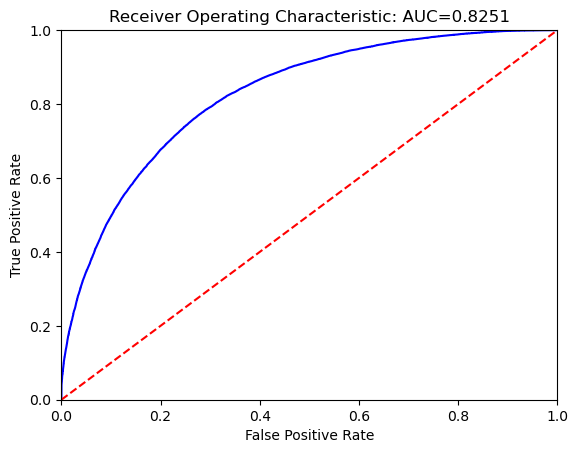

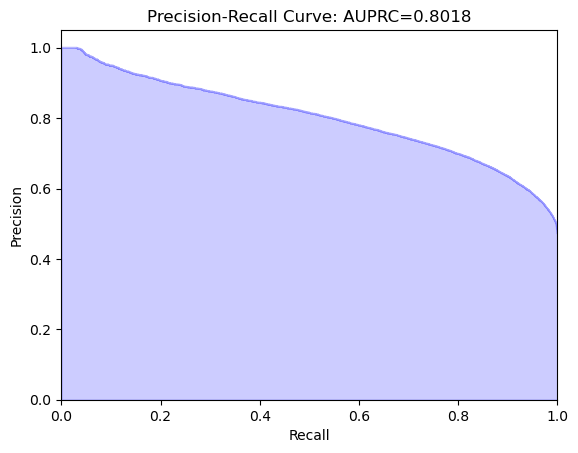

In [205]:
print("MLP:") #0.8251

probs = model.predict(X_test_b.astype(np.float32))
result = PlotROCCurve(probs,y_test_b, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_tuned_with_MinMaxScaling"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

(vi) Performance Output for MLP

In [206]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_mlp, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
#formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,MLP_base,0.445,0.822 (0.82-0.825),0.8 (0.796-0.802),0.751 (0.741-0.759),0.738 (0.73-0.746),48.636
1,MLP_base_variables_with_features_caling,0.495,0.821 (0.819-0.824),0.797 (0.793-0.8),0.745 (0.742-0.762),0.741 (0.724-0.745),45.299
2,MLP_add_variables_with_MinMax,0.435,0.82 (0.817-0.822),0.794 (0.79-0.796),0.758 (0.744-0.77),0.729 (0.72-0.741),46.724
3,MLP_add_variables_with_RobustScaler,0.500,0.821 (0.818-0.823),0.795 (0.79-0.797),0.744 (0.739-0.765),0.742 (0.721-0.746),45.111
4,MLP_add_variables_with_MinMax,0.532,0.819 (0.816-0.821),0.792 (0.788-0.794),0.74 (0.736-0.76),0.744 (0.724-0.747),58.601
5,MLP_tuned_with_MinMaxScaling,0.485,0.825 (0.823-0.827),0.802 (0.798-0.804),0.761 (0.75-0.767),0.733 (0.729-0.74),78.222


(vii) Feature importance using Sharpley

In [207]:
import shap

In [211]:
#Convert pandas DataFrames to numpy arrays:
X_test_array = X_test_b.values.astype(np.float32)
y_test_array = y_test_b.values.astype(np.float32)

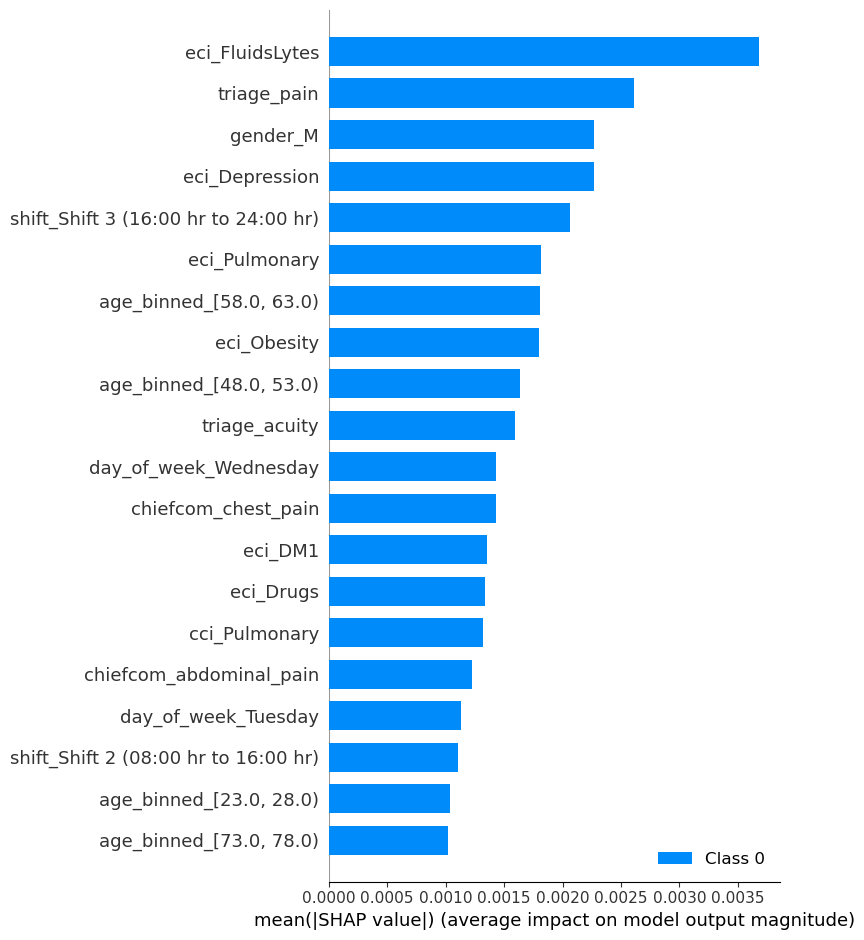

In [223]:
# SHAP library may not have a registered gradient function for the LeakyReLU activation function. 
# SHAP requires access to gradient information for all operations in the computation graph to accurately compute SHAP values.
#To work around this issue, you can replace the LeakyReLU activation function with a different activation function that SHAP
# supports (e.g., ReLU or Sigmoid) when using the DeepExplainer.
# Build MLP model

# 3 Layers MLP
model = Sequential()
model.add(Dense(16, input_dim=X_train_array.shape[1], activation='relu'))  # Use ReLU instead of LeakyReLU
model.add(Dropout(0.0))
for i in range(3):
    model.add(Dense(16, activation='relu'))  # Use ReLU instead of LeakyReLU
    model.add(Dropout(0.0))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.01), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])

# Define your feature names based on your dataset columns
feature_names = list(X_train_b.columns)


# Define the background dataset for SHAP values
background_indices = np.random.choice(X_train_array.shape[0], 100, replace=False)
background = X_train_array[background_indices]

# Create an explainer object using the SHAP library
explainer = shap.DeepExplainer(model, background)

# Generate SHAP values for the test set
shap_values = explainer.shap_values(X_test_array)

# Plot the SHAP values for the  test set
shap.summary_plot(shap_values, X_test_array, feature_names=feature_names, plot_type='bar')
